In [3]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 3
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

#Since the NaN values of GHI are gone which is used in data preparation, simulate these in solar activity instead
df['solar_activity'].loc[df['Year'] > 2020] = np.nan
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['GHI'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    #new_df = new_df.iloc[:180, :]
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df) 

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)     

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 3
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  specific_humidity          slp  vapor_pressure  \
0      2006-01-31     6501           5.386935  1018.534543        8.674922   
1      2006-02-28     6501           4.299929  1021.230347        6.942276   
2      2006-03-31     6501           6.505135  1018.968548       10.468176   
3      2006-04-30     6501          10.211263  1014.686944       16.358802   
4      2006-05-31     6501          11.737971  1014.236828       18.798749   
...           ...      ...                ...          ...             ...   
24057  2024-07-31     9858          15.211417  1013.969355       23.769169   
24058  2024-08-31     9858          15.149811  1015.112097       23.699154   
24059  2024-09-30     9858          10.720199  1014.393750       16.790240   
24060  2024-10-31     9858           6.989922  1018.230376       10

C:\Users\User\AppData\Local\Temp\ipykernel_659300\3209935344.py:383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solar_activity'].loc[df['Year'] > 2020] = np.nan


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 1:
(84, 1, 1, 1972)
(11, 1, 1, 1972)
(10, 1, 1, 1972)
(84, 1, 1972)
(11, 1, 1972)
(10, 1, 1972)
(84, 1972)
(11, 1972)
(10, 1972)
[[0.42725031 0.69695044 0.32924264 ... 0.50924784 0.43464858 0.67200986]
 [0.45745993 0.51683609 0.42215989 ... 0.52342787 0.62453761 0.5       ]
 [0.43218249 0.62674714 0.3411641  ... 0.48766954 0.45745993 0.70406905]
 ...
 [0.47102343 0.46473952 0.46949509 ... 0.55487053 0.54192355 0.52342787]
 [0.43464858 0.51620076 0.3997195  ... 0.52959309 0.56966708 0.57768187]
 [0.44389642 0.52414231 0.42356241 ... 0.47040691 0.71824908 0.40197287]]
Fold 2:
(84, 1, 1, 1972)
(11, 1, 1, 1972)
(10, 1, 1, 1972)
(84, 1, 1972)
(11, 1, 1972)
(10, 1, 1972)
(84, 1972)
(11, 1972)
(10, 1972)
[[0.43464858 0.62313675 0.34639831 ... 0.48705302 0.47163995 0.6972873 ]
 [0.42725031 0.71548931 0.32450565 ... 0.50924784 0.43464858 0.67200986]
 [0.45745993 0.53175632 0.4180791  ... 0.52342787 0.62453761 0.5       ]
 ...
 [0.47102343 0.47861309 0.465

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

3
179
(84, 1972)
(11, 1972)


[I 2025-05-20 16:03:46,522] A new study created in memory with name: no-name-63b1f0f6-53e4-4236-953d-6b59cca0f37b
[I 2025-05-20 16:09:24,449] Trial 0 finished with value: 0.047385942190885544 and parameters: {'lr': 0.0019712191980188493, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.39027659720238006}. Best is trial 0 with value: 0.047385942190885544.


Cross Validation Accuracies:
[0.03969994932413101, 0.03937637805938721, 0.06549858301877975, 0.0449717752635479, 0.04738302528858185]
Mean Cross Validation Accuracy:
0.047385942190885544
Standard Deviation of Cross Validation Accuracy:
0.009561627185223825


[I 2025-05-20 16:13:12,651] Trial 1 finished with value: 0.08048836886882782 and parameters: {'lr': 0.4997044678180616, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2806252628206354}. Best is trial 0 with value: 0.047385942190885544.


Cross Validation Accuracies:
[0.06828233599662781, 0.07148715108633041, 0.09868619590997696, 0.09146168828010559, 0.07252447307109833]
Mean Cross Validation Accuracy:
0.08048836886882782
Standard Deviation of Cross Validation Accuracy:
0.012206616601202584


[I 2025-05-20 16:16:44,095] Trial 2 finished with value: 1.1772304892539978 and parameters: {'lr': 0.40457032312265284, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.25296685214647885}. Best is trial 0 with value: 0.047385942190885544.


Cross Validation Accuracies:
[1.938077449798584, 0.937274694442749, 1.2049295902252197, 0.6168888211250305, 1.1889818906784058]
Mean Cross Validation Accuracy:
1.1772304892539978
Standard Deviation of Cross Validation Accuracy:
0.43620064225194316


[I 2025-05-20 16:23:34,840] Trial 3 finished with value: 0.24820619225502014 and parameters: {'lr': 0.5006405342655331, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.35860234579037786}. Best is trial 0 with value: 0.047385942190885544.


Cross Validation Accuracies:
[0.2338104397058487, 0.2510169446468353, 0.2497408390045166, 0.239190474152565, 0.2672722637653351]
Mean Cross Validation Accuracy:
0.24820619225502014
Standard Deviation of Cross Validation Accuracy:
0.011509052235959237


[I 2025-05-20 16:28:22,016] Trial 4 finished with value: 2.4840109586715697 and parameters: {'lr': 0.2814099946058474, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2793734096456363}. Best is trial 0 with value: 0.047385942190885544.


Cross Validation Accuracies:
[2.9835212230682373, 2.304595708847046, 1.70619535446167, 1.3386930227279663, 4.08704948425293]
Mean Cross Validation Accuracy:
2.4840109586715697
Standard Deviation of Cross Validation Accuracy:
0.9765432032584951


[I 2025-05-20 16:35:02,416] Trial 5 finished with value: 0.13949646055698395 and parameters: {'lr': 0.24639266463300466, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3699431377036886}. Best is trial 0 with value: 0.047385942190885544.


Cross Validation Accuracies:
[0.13149254024028778, 0.1460687220096588, 0.13911119103431702, 0.1293349713087082, 0.15147487819194794]
Mean Cross Validation Accuracy:
0.13949646055698395
Standard Deviation of Cross Validation Accuracy:
0.008415986530691142


[I 2025-05-20 16:38:09,500] Trial 6 finished with value: 2.9750627517700194 and parameters: {'lr': 0.2551844810891019, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.46168373681829145}. Best is trial 0 with value: 0.047385942190885544.


Cross Validation Accuracies:
[4.818363666534424, 1.5417479276657104, 3.381744146347046, 3.264697790145874, 1.8687602281570435]
Mean Cross Validation Accuracy:
2.9750627517700194
Standard Deviation of Cross Validation Accuracy:
1.176888536206466


[I 2025-05-20 16:42:03,711] Trial 7 finished with value: 0.0437421590089798 and parameters: {'lr': 0.004086655572047574, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.22088906995176175}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.034318406134843826, 0.03468118607997894, 0.06203904002904892, 0.043172888457775116, 0.04449927434325218]
Mean Cross Validation Accuracy:
0.0437421590089798
Standard Deviation of Cross Validation Accuracy:
0.01006559979638866


[I 2025-05-20 16:49:26,158] Trial 8 finished with value: 0.4222027510404587 and parameters: {'lr': 0.07061267055823311, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.33645305784505775}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.23691295087337494, 0.2963770031929016, 0.7062488198280334, 0.5024809241294861, 0.3689940571784973]
Mean Cross Validation Accuracy:
0.4222027510404587
Standard Deviation of Cross Validation Accuracy:
0.1674051063964527


[I 2025-05-20 16:52:17,311] Trial 9 finished with value: 0.06566918417811393 and parameters: {'lr': 0.3869034832715144, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.10659105281410418}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.07223672419786453, 0.0484900027513504, 0.08722098916769028, 0.046395193785429, 0.07400301098823547]
Mean Cross Validation Accuracy:
0.06566918417811393
Standard Deviation of Cross Validation Accuracy:
0.015771344455510584


[I 2025-05-20 16:54:56,842] Trial 10 finished with value: 0.055541292577981946 and parameters: {'lr': 0.003611381626202142, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.15412618939662204}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.05333341658115387, 0.041092827916145325, 0.07032766938209534, 0.05566323176026344, 0.05728931725025177]
Mean Cross Validation Accuracy:
0.055541292577981946
Standard Deviation of Cross Validation Accuracy:
0.009331026159152843


[I 2025-05-20 16:57:16,195] Trial 11 finished with value: 0.04732450395822525 and parameters: {'lr': 0.0013890964291379375, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.4511698906955059}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.04545917361974716, 0.03591083362698555, 0.056750860065221786, 0.047722186893224716, 0.05077946558594704]
Mean Cross Validation Accuracy:
0.04732450395822525
Standard Deviation of Cross Validation Accuracy:
0.006851312702301637


[I 2025-05-20 16:59:22,674] Trial 12 finished with value: 0.045651602745056155 and parameters: {'lr': 0.00764127571021104, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.49396910023041096}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.03370772302150726, 0.034829333424568176, 0.06663919985294342, 0.04629993438720703, 0.04678182303905487]
Mean Cross Validation Accuracy:
0.045651602745056155
Standard Deviation of Cross Validation Accuracy:
0.011848668619637872


[I 2025-05-20 17:01:39,924] Trial 13 finished with value: 0.07811117470264435 and parameters: {'lr': 0.011130803844660392, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.19932498184510983}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.06953877955675125, 0.0791470929980278, 0.09260589629411697, 0.07862190902233124, 0.07064219564199448]
Mean Cross Validation Accuracy:
0.07811117470264435
Standard Deviation of Cross Validation Accuracy:
0.008254726367603916


[I 2025-05-20 17:04:24,092] Trial 14 finished with value: 0.5304280817508698 and parameters: {'lr': 0.009109608186548952, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.49893479706561283}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.4501339793205261, 0.6042886972427368, 0.466457337141037, 0.5435547232627869, 0.587705671787262]
Mean Cross Validation Accuracy:
0.5304280817508698
Standard Deviation of Cross Validation Accuracy:
0.06236637011984551


[I 2025-05-20 17:06:59,760] Trial 15 finished with value: 0.0817532330751419 and parameters: {'lr': 0.021543098952467938, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.21693465348659252}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.08806343376636505, 0.05563272535800934, 0.11569812148809433, 0.08031050115823746, 0.06906138360500336]
Mean Cross Validation Accuracy:
0.0817532330751419
Standard Deviation of Cross Validation Accuracy:
0.020186725954888265


[I 2025-05-20 17:08:52,419] Trial 16 finished with value: 0.052131982147693635 and parameters: {'lr': 0.004981837900920152, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.41792228196308684}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.05180369317531586, 0.032829876989126205, 0.06501131504774094, 0.051726117730140686, 0.059288907796144485]
Mean Cross Validation Accuracy:
0.052131982147693635
Standard Deviation of Cross Validation Accuracy:
0.010862251735389954


[I 2025-05-20 17:10:54,201] Trial 17 finished with value: 0.5862439274787903 and parameters: {'lr': 0.05436882705851613, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.3130982350039663}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.6573947072029114, 0.4750537574291229, 0.6645063757896423, 0.8201534748077393, 0.3141113221645355]
Mean Cross Validation Accuracy:
0.5862439274787903
Standard Deviation of Cross Validation Accuracy:
0.1745396971427365


[I 2025-05-20 17:13:14,900] Trial 18 finished with value: 0.1386019065976143 and parameters: {'lr': 0.0214099864766338, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18681442318283303}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.1662725806236267, 0.14125628769397736, 0.13184905052185059, 0.1206376776099205, 0.1329939365386963]
Mean Cross Validation Accuracy:
0.1386019065976143
Standard Deviation of Cross Validation Accuracy:
0.015313235167936038


[I 2025-05-20 17:17:25,370] Trial 19 finished with value: 0.06883794367313385 and parameters: {'lr': 0.003339033397602238, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2384978400467208}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.09342613816261292, 0.0487128347158432, 0.08783034235239029, 0.06111542135477066, 0.053104981780052185]
Mean Cross Validation Accuracy:
0.06883794367313385
Standard Deviation of Cross Validation Accuracy:
0.018316516957510607


[I 2025-05-20 17:19:37,330] Trial 20 finished with value: 0.044211356341838835 and parameters: {'lr': 0.0010241149687403456, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13649735381214662}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.03996758535504341, 0.03598780557513237, 0.05598457157611847, 0.04492662101984024, 0.04419019818305969]
Mean Cross Validation Accuracy:
0.044211356341838835
Standard Deviation of Cross Validation Accuracy:
0.006704580935165427


[I 2025-05-20 17:21:31,634] Trial 21 finished with value: 0.04489402398467064 and parameters: {'lr': 0.0011752806538581442, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13118498628729158}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.04249269515275955, 0.03498439863324165, 0.056392356753349304, 0.04389408603310585, 0.046706583350896835]
Mean Cross Validation Accuracy:
0.04489402398467064
Standard Deviation of Cross Validation Accuracy:
0.0069348966623446525


[I 2025-05-20 17:23:20,380] Trial 22 finished with value: 0.04450782835483551 and parameters: {'lr': 0.0012302649849531594, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.10255515369013896}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.040246862918138504, 0.034640587866306305, 0.056524500250816345, 0.04650982841849327, 0.044617362320423126]
Mean Cross Validation Accuracy:
0.04450782835483551
Standard Deviation of Cross Validation Accuracy:
0.007265516729199035


[I 2025-05-20 17:25:13,633] Trial 23 finished with value: 0.04545018449425697 and parameters: {'lr': 0.0022203469141718808, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.15950704203803517}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.04288759082555771, 0.03334088996052742, 0.056008026003837585, 0.04594044387340546, 0.049073971807956696]
Mean Cross Validation Accuracy:
0.04545018449425697
Standard Deviation of Cross Validation Accuracy:
0.007457105423831254


[I 2025-05-20 17:27:15,203] Trial 24 finished with value: 0.04492618665099144 and parameters: {'lr': 0.001020711998438026, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.10504763132020897}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.041991155594587326, 0.03546556085348129, 0.056638721376657486, 0.04463111236691475, 0.045904383063316345]
Mean Cross Validation Accuracy:
0.04492618665099144
Standard Deviation of Cross Validation Accuracy:
0.006875249152382958


[I 2025-05-20 17:29:15,779] Trial 25 finished with value: 0.050981432944536206 and parameters: {'lr': 0.0021958671161732093, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13882043948410538}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.04903489723801613, 0.04294638708233833, 0.06127401813864708, 0.04330172762274742, 0.05835013464093208]
Mean Cross Validation Accuracy:
0.050981432944536206
Standard Deviation of Cross Validation Accuracy:
0.007583718240578161


[I 2025-05-20 17:31:08,322] Trial 26 finished with value: 0.05062382817268372 and parameters: {'lr': 0.00555373878323272, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.16919086396617938}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.05060596764087677, 0.04189418628811836, 0.05506376177072525, 0.053876761347055435, 0.05167846381664276]
Mean Cross Validation Accuracy:
0.05062382817268372
Standard Deviation of Cross Validation Accuracy:
0.004639263031232637


[I 2025-05-20 17:32:59,976] Trial 27 finished with value: 0.045542821288108826 and parameters: {'lr': 0.002887320750232571, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12218976103091561}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.04031739756464958, 0.03779492527246475, 0.05743512138724327, 0.04366212710738182, 0.0485045351088047]
Mean Cross Validation Accuracy:
0.045542821288108826
Standard Deviation of Cross Validation Accuracy:
0.006943637472736008


[I 2025-05-20 17:35:55,618] Trial 28 finished with value: 0.0773044541478157 and parameters: {'lr': 0.0016622634258548876, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2235667967822877}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.06319203227758408, 0.0662764385342598, 0.09547882527112961, 0.09057354182004929, 0.07100143283605576]
Mean Cross Validation Accuracy:
0.0773044541478157
Standard Deviation of Cross Validation Accuracy:
0.013167248083438637


[I 2025-05-20 17:40:17,245] Trial 29 finished with value: 0.05106880813837052 and parameters: {'lr': 0.001054394467058405, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1854059197148536}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.0372004397213459, 0.055787038058042526, 0.05542830377817154, 0.04501811042428017, 0.061910148710012436]
Mean Cross Validation Accuracy:
0.05106880813837052
Standard Deviation of Cross Validation Accuracy:
0.008806181312876603


[I 2025-05-20 17:44:41,253] Trial 30 finished with value: 0.048365405201911925 and parameters: {'lr': 0.004235095251561474, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.14090061338683446}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.04947995766997337, 0.03395993635058403, 0.06306041032075882, 0.04525909200310707, 0.05006762966513634]
Mean Cross Validation Accuracy:
0.048365405201911925
Standard Deviation of Cross Validation Accuracy:
0.009351467107206713


[I 2025-05-20 17:47:04,157] Trial 31 finished with value: 0.04408700913190842 and parameters: {'lr': 0.0017364334984434552, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12960958648581666}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.04112890735268593, 0.034924548119306564, 0.05616779625415802, 0.043277863413095474, 0.0449359305202961]
Mean Cross Validation Accuracy:
0.04408700913190842
Standard Deviation of Cross Validation Accuracy:
0.0069285187414733235


[I 2025-05-20 17:49:12,289] Trial 32 finished with value: 0.04517484903335571 and parameters: {'lr': 0.0020189012488000192, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.10435366473240683}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.0419028103351593, 0.034602899104356766, 0.05659215524792671, 0.04773934185504913, 0.04503703862428665]
Mean Cross Validation Accuracy:
0.04517484903335571
Standard Deviation of Cross Validation Accuracy:
0.0072030945972186445


[I 2025-05-20 17:51:07,974] Trial 33 finished with value: 0.04429258033633232 and parameters: {'lr': 0.00267229092209405, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.17033916259919532}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.03767300024628639, 0.03914756327867508, 0.054880689829587936, 0.04191136360168457, 0.04785028472542763]
Mean Cross Validation Accuracy:
0.04429258033633232
Standard Deviation of Cross Validation Accuracy:
0.0063360170042518135


[I 2025-05-20 17:53:17,811] Trial 34 finished with value: 0.09392102658748627 and parameters: {'lr': 0.012969648978272968, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.25554985236868133}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.1129901334643364, 0.09378504753112793, 0.08967629820108414, 0.07601084560155869, 0.09714280813932419]
Mean Cross Validation Accuracy:
0.09392102658748627
Standard Deviation of Cross Validation Accuracy:
0.011940029361565858


[I 2025-05-20 17:55:36,711] Trial 35 finished with value: 0.04589536935091019 and parameters: {'lr': 0.006332087452847854, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.17325419068889422}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.0331377275288105, 0.033037494868040085, 0.06148412451148033, 0.04248024523258209, 0.059337254613637924]
Mean Cross Validation Accuracy:
0.04589536935091019
Standard Deviation of Cross Validation Accuracy:
0.012356690501055327


[I 2025-05-20 17:58:07,914] Trial 36 finished with value: 0.06509717851877213 and parameters: {'lr': 0.002812058015251352, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.21337393318852926}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.04489850252866745, 0.08296362310647964, 0.08078953623771667, 0.04886831343173981, 0.06796591728925705]
Mean Cross Validation Accuracy:
0.06509717851877213
Standard Deviation of Cross Validation Accuracy:
0.015780064441468882


[I 2025-05-20 17:59:58,995] Trial 37 finished with value: 0.04509428068995476 and parameters: {'lr': 0.0017890685372535886, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2728573967720012}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.04174303263425827, 0.036863841116428375, 0.05624636635184288, 0.04515860602259636, 0.0454595573246479]
Mean Cross Validation Accuracy:
0.04509428068995476
Standard Deviation of Cross Validation Accuracy:
0.0063793036999760635


[I 2025-05-20 18:05:07,100] Trial 38 finished with value: 2.4075918912887575 and parameters: {'lr': 0.10625745491022266, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.19905554116717136}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[1.4566223621368408, 1.9282363653182983, 1.6378121376037598, 3.705622673034668, 3.3096659183502197]
Mean Cross Validation Accuracy:
2.4075918912887575
Standard Deviation of Cross Validation Accuracy:
0.9192722225212674


[I 2025-05-20 18:07:07,352] Trial 39 finished with value: 0.04636436030268669 and parameters: {'lr': 0.015135328899064271, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.15085793244180953}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.0465891994535923, 0.032575540244579315, 0.054925087839365005, 0.046069469302892685, 0.05166250467300415]
Mean Cross Validation Accuracy:
0.04636436030268669
Standard Deviation of Cross Validation Accuracy:
0.007637086639110136


[I 2025-05-20 18:09:13,945] Trial 40 finished with value: 0.04657426401972771 and parameters: {'lr': 0.0023480228511130173, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2948388906770799}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.03991476446390152, 0.04080038517713547, 0.05881704017519951, 0.04879982769489288, 0.044539302587509155]
Mean Cross Validation Accuracy:
0.04657426401972771
Standard Deviation of Cross Validation Accuracy:
0.006879918326823424


[I 2025-05-20 18:11:16,270] Trial 41 finished with value: 0.044615364819765094 and parameters: {'lr': 0.0010351867015325953, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12033328778811622}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.04027808457612991, 0.034753523766994476, 0.05596056953072548, 0.04621781036257744, 0.04586683586239815]
Mean Cross Validation Accuracy:
0.044615364819765094
Standard Deviation of Cross Validation Accuracy:
0.007055715276054808


[I 2025-05-20 18:13:32,463] Trial 42 finished with value: 0.13460491746664047 and parameters: {'lr': 0.7732659435655429, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12147305882065104}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.15209150314331055, 0.11673080176115036, 0.1333124339580536, 0.1269758939743042, 0.14391395449638367]
Mean Cross Validation Accuracy:
0.13460491746664047
Standard Deviation of Cross Validation Accuracy:
0.012424132761432399


[I 2025-05-20 18:15:20,623] Trial 43 finished with value: 0.04436096027493477 and parameters: {'lr': 0.001570207496279468, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.16913044436219}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.040639445185661316, 0.035113994032144547, 0.05605233088135719, 0.04584690183401108, 0.04415212944149971]
Mean Cross Validation Accuracy:
0.04436096027493477
Standard Deviation of Cross Validation Accuracy:
0.0069035619580864694


[I 2025-05-20 18:17:17,846] Trial 44 finished with value: 0.044842276722192764 and parameters: {'lr': 0.0014813618264125925, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1760653422652354}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.042403701692819595, 0.034635625779628754, 0.055811699479818344, 0.04553791508078575, 0.04582244157791138]
Mean Cross Validation Accuracy:
0.044842276722192764
Standard Deviation of Cross Validation Accuracy:
0.006810216489115026


[I 2025-05-20 18:19:22,595] Trial 45 finished with value: 0.05788829699158669 and parameters: {'lr': 0.0038765231681155907, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.24049508205717637}. Best is trial 7 with value: 0.0437421590089798.


Cross Validation Accuracies:
[0.0576099157333374, 0.05448782071471214, 0.0598704069852829, 0.07046159356832504, 0.04701174795627594]
Mean Cross Validation Accuracy:
0.05788829699158669
Standard Deviation of Cross Validation Accuracy:
0.0076414213440404


[I 2025-05-20 18:22:42,151] Trial 46 finished with value: 0.04334330335259438 and parameters: {'lr': 0.0015986752804735206, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1536002396622364}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.036233339458703995, 0.03196238726377487, 0.05568957328796387, 0.05020364373922348, 0.042627573013305664]
Mean Cross Validation Accuracy:
0.04334330335259438
Standard Deviation of Cross Validation Accuracy:
0.008718758616330386


[I 2025-05-20 18:26:02,306] Trial 47 finished with value: 0.048419360816478726 and parameters: {'lr': 0.006888724842116867, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.14675214773674797}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.04319094493985176, 0.03715923801064491, 0.05968208611011505, 0.04968523606657982, 0.0523792989552021]
Mean Cross Validation Accuracy:
0.048419360816478726
Standard Deviation of Cross Validation Accuracy:
0.007723460745451789


[I 2025-05-20 18:31:35,174] Trial 48 finished with value: 0.06769225522875785 and parameters: {'lr': 0.0028562702164640144, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.19390348057549117}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.038484521210193634, 0.0755784809589386, 0.11896666884422302, 0.051984891295433044, 0.05344671383500099]
Mean Cross Validation Accuracy:
0.06769225522875785
Standard Deviation of Cross Validation Accuracy:
0.02826307310152777


[I 2025-05-20 18:35:40,248] Trial 49 finished with value: 0.05773077979683876 and parameters: {'lr': 0.0046840986887892915, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.20638039583543538}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.04747213423252106, 0.07905522733926773, 0.0566304549574852, 0.044523514807224274, 0.06097256764769554]
Mean Cross Validation Accuracy:
0.05773077979683876
Standard Deviation of Cross Validation Accuracy:
0.0122157572301684


[I 2025-05-20 18:39:13,884] Trial 50 finished with value: 0.04905756711959839 and parameters: {'lr': 0.043703113127285045, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.15487892122917662}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.04261386767029762, 0.03164219111204147, 0.06009964644908905, 0.06131615489721298, 0.049615975469350815]
Mean Cross Validation Accuracy:
0.04905756711959839
Standard Deviation of Cross Validation Accuracy:
0.011111515595838653


[I 2025-05-20 18:41:34,158] Trial 51 finished with value: 0.044603950530290606 and parameters: {'lr': 0.0016668335597159896, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.16520356387435375}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.0417315736413002, 0.03228229656815529, 0.05531996861100197, 0.04579228535294533, 0.04789362847805023]
Mean Cross Validation Accuracy:
0.044603950530290606
Standard Deviation of Cross Validation Accuracy:
0.007578137891485663


[I 2025-05-20 18:45:15,632] Trial 52 finished with value: 0.04672742486000061 and parameters: {'lr': 0.0013795000915013001, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.12931402283742097}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.03831303119659424, 0.04175404831767082, 0.056116972118616104, 0.05167194828391075, 0.045781124383211136]
Mean Cross Validation Accuracy:
0.04672742486000061
Standard Deviation of Cross Validation Accuracy:
0.00646597075709922


[I 2025-05-20 18:47:16,359] Trial 53 finished with value: 0.07018499597907066 and parameters: {'lr': 0.1465290387856213, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18512763545685434}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.07151281833648682, 0.0566103421151638, 0.07708381861448288, 0.0725843608379364, 0.07313363999128342]
Mean Cross Validation Accuracy:
0.07018499597907066
Standard Deviation of Cross Validation Accuracy:
0.007043856141763963


[I 2025-05-20 18:48:58,413] Trial 54 finished with value: 0.044468775391578674 and parameters: {'lr': 0.002328270121259007, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.22591952170252136}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.04127565771341324, 0.037019092589616776, 0.055121682584285736, 0.04494023323059082, 0.0439872108399868]
Mean Cross Validation Accuracy:
0.044468775391578674
Standard Deviation of Cross Validation Accuracy:
0.005993869917243871


[I 2025-05-20 18:50:49,058] Trial 55 finished with value: 0.04714766070246697 and parameters: {'lr': 0.003202103046816201, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.35734824254343794}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.039382435381412506, 0.039387911558151245, 0.05653616040945053, 0.052866335958242416, 0.047565460205078125]
Mean Cross Validation Accuracy:
0.04714766070246697
Standard Deviation of Cross Validation Accuracy:
0.006950311660967224


[I 2025-05-20 18:52:24,290] Trial 56 finished with value: 0.047043119370937345 and parameters: {'lr': 0.0015019436053223222, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.16100342035175938}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.04222851246595383, 0.04126372188329697, 0.06203790009021759, 0.04733041301369667, 0.04235504940152168]
Mean Cross Validation Accuracy:
0.047043119370937345
Standard Deviation of Cross Validation Accuracy:
0.007790838998006111


[I 2025-05-20 18:54:20,722] Trial 57 finished with value: 0.05096611306071282 and parameters: {'lr': 0.0018134640741390333, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.13862532024741808}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.06455615162849426, 0.03367314860224724, 0.06686047464609146, 0.042148690670728683, 0.047592099756002426]
Mean Cross Validation Accuracy:
0.05096611306071282
Standard Deviation of Cross Validation Accuracy:
0.012849104261590047


[I 2025-05-20 18:56:24,125] Trial 58 finished with value: 0.04558494091033936 and parameters: {'lr': 0.0013373433038236457, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.17810187998179502}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.04221319034695625, 0.03598875552415848, 0.05650931969285011, 0.04563717544078827, 0.047576263546943665]
Mean Cross Validation Accuracy:
0.04558494091033936
Standard Deviation of Cross Validation Accuracy:
0.0067344728360966884


[I 2025-05-20 19:01:38,631] Trial 59 finished with value: 0.1175913468003273 and parameters: {'lr': 0.0025664321240375662, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1165030175173897}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.09256995469331741, 0.11886907368898392, 0.10909376293420792, 0.13441061973571777, 0.13301332294940948]
Mean Cross Validation Accuracy:
0.1175913468003273
Standard Deviation of Cross Validation Accuracy:
0.015624575968355004


[I 2025-05-20 19:03:32,791] Trial 60 finished with value: 0.06594897210597991 and parameters: {'lr': 0.008060056402825477, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.32293665449085196}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.06704399734735489, 0.042808420956134796, 0.08285479992628098, 0.06779003143310547, 0.06924761086702347]
Mean Cross Validation Accuracy:
0.06594897210597991
Standard Deviation of Cross Validation Accuracy:
0.012936473392771052


[I 2025-05-20 19:05:29,460] Trial 61 finished with value: 0.044480641931295396 and parameters: {'lr': 0.002106461867845736, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.22944918645593798}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.04150968790054321, 0.034368786960840225, 0.055669475346803665, 0.04285620152950287, 0.047999057918787]
Mean Cross Validation Accuracy:
0.044480641931295396
Standard Deviation of Cross Validation Accuracy:
0.007089206297976783


[I 2025-05-20 19:07:28,477] Trial 62 finished with value: 0.046195152401924136 and parameters: {'lr': 0.003644329880678821, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2603246402821847}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.04414110258221626, 0.033382922410964966, 0.058459069579839706, 0.048044655472040176, 0.046948011964559555]
Mean Cross Validation Accuracy:
0.046195152401924136
Standard Deviation of Cross Validation Accuracy:
0.008034469262835827


[I 2025-05-20 19:09:21,868] Trial 63 finished with value: 0.044214972853660585 and parameters: {'lr': 0.001310951620108537, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.23851218018121245}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.0416778102517128, 0.03417906537652016, 0.05633045360445976, 0.04399345815181732, 0.04489407688379288]
Mean Cross Validation Accuracy:
0.044214972853660585
Standard Deviation of Cross Validation Accuracy:
0.00713374737186993


[I 2025-05-20 19:11:10,160] Trial 64 finished with value: 0.04513671547174454 and parameters: {'lr': 0.0012901385561461475, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.24257783359341567}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.04039250686764717, 0.035490483045578, 0.0573321208357811, 0.047249142080545425, 0.04521932452917099]
Mean Cross Validation Accuracy:
0.04513671547174454
Standard Deviation of Cross Validation Accuracy:
0.007331499133546001


[I 2025-05-20 19:12:59,579] Trial 65 finished with value: 0.04451887980103493 and parameters: {'lr': 0.0018300848582977808, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.20889145144140395}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.036174651235342026, 0.03575500473380089, 0.05660998448729515, 0.04780815541744232, 0.04624660313129425]
Mean Cross Validation Accuracy:
0.04451887980103493
Standard Deviation of Cross Validation Accuracy:
0.007828548154943295


[I 2025-05-20 19:14:39,693] Trial 66 finished with value: 0.0599578931927681 and parameters: {'lr': 0.001007708939646362, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.1344075895762498}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.04946168512105942, 0.04781194031238556, 0.06222743168473244, 0.06062370166182518, 0.07966470718383789]
Mean Cross Validation Accuracy:
0.0599578931927681
Standard Deviation of Cross Validation Accuracy:
0.01141619182406879


[I 2025-05-20 19:16:34,652] Trial 67 finished with value: 0.046720095723867414 and parameters: {'lr': 0.005466823129337027, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.19286314203038146}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.04742654785513878, 0.03396965563297272, 0.057110872119665146, 0.0509086512029171, 0.04418475180864334]
Mean Cross Validation Accuracy:
0.046720095723867414
Standard Deviation of Cross Validation Accuracy:
0.007681314952562234


[I 2025-05-20 19:18:51,370] Trial 68 finished with value: 0.04389555901288986 and parameters: {'lr': 0.001221188055895549, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1505733315818652}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.04041700437664986, 0.033233899623155594, 0.056336402893066406, 0.04457910358905792, 0.04491138458251953]
Mean Cross Validation Accuracy:
0.04389555901288986
Standard Deviation of Cross Validation Accuracy:
0.007510593245895615


[I 2025-05-20 19:20:51,984] Trial 69 finished with value: 0.04483832493424415 and parameters: {'lr': 0.0012220748457850916, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14942129206359264}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.04185943678021431, 0.03553048521280289, 0.05565235763788223, 0.04559978470206261, 0.04554956033825874]
Mean Cross Validation Accuracy:
0.04483832493424415
Standard Deviation of Cross Validation Accuracy:
0.006535114918768346


[I 2025-05-20 19:23:32,791] Trial 70 finished with value: 0.0513302743434906 and parameters: {'lr': 0.0026352932508823712, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.11358435579309589}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.052868470549583435, 0.0318903811275959, 0.06725678592920303, 0.04309474676847458, 0.061540987342596054]
Mean Cross Validation Accuracy:
0.0513302743434906
Standard Deviation of Cross Validation Accuracy:
0.012696549464264769


[I 2025-05-20 19:25:41,863] Trial 71 finished with value: 0.04453474059700966 and parameters: {'lr': 0.0014578890230013272, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16923722531831076}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.04115010052919388, 0.03416171297430992, 0.05551943928003311, 0.04590883105993271, 0.045933619141578674]
Mean Cross Validation Accuracy:
0.04453474059700966
Standard Deviation of Cross Validation Accuracy:
0.006979456732289765


[I 2025-05-20 19:27:33,187] Trial 72 finished with value: 0.04419753178954124 and parameters: {'lr': 0.0019258832707015276, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.13087828302560806}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.040520742535591125, 0.03427663445472717, 0.05629385635256767, 0.044303808361291885, 0.045592617243528366]
Mean Cross Validation Accuracy:
0.04419753178954124
Standard Deviation of Cross Validation Accuracy:
0.007214175063215337


[I 2025-05-20 19:29:22,276] Trial 73 finished with value: 0.045158413052558896 and parameters: {'lr': 0.0019439781096883457, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1358877646959044}. Best is trial 46 with value: 0.04334330335259438.


Cross Validation Accuracies:
[0.04011870548129082, 0.03633507713675499, 0.05665978044271469, 0.0477786548435688, 0.044899847358465195]
Mean Cross Validation Accuracy:
0.045158413052558896
Standard Deviation of Cross Validation Accuracy:
0.0069636755264998965


[I 2025-05-20 19:31:26,974] Trial 74 finished with value: 0.04316224306821823 and parameters: {'lr': 0.0030357832121815937, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.12743527193059515}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.03646571561694145, 0.032479576766490936, 0.057501789182424545, 0.044312939047813416, 0.04505119472742081]
Mean Cross Validation Accuracy:
0.04316224306821823
Standard Deviation of Cross Validation Accuracy:
0.008596251061823094


[I 2025-05-20 19:33:26,697] Trial 75 finished with value: 0.04424175694584846 and parameters: {'lr': 0.0011244026513301082, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.11046378201923379}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.04131843522191048, 0.03394847735762596, 0.05692249536514282, 0.043763842433691025, 0.04525553435087204]
Mean Cross Validation Accuracy:
0.04424175694584846
Standard Deviation of Cross Validation Accuracy:
0.007437132355275127


[I 2025-05-20 19:35:33,304] Trial 76 finished with value: 0.04798739179968834 and parameters: {'lr': 0.0035104327524184955, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1262962385191308}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.041663892567157745, 0.04609381780028343, 0.056937988847494125, 0.04887251555919647, 0.04636874422430992]
Mean Cross Validation Accuracy:
0.04798739179968834
Standard Deviation of Cross Validation Accuracy:
0.005041605232267818


[I 2025-05-20 19:38:17,424] Trial 77 finished with value: 0.1533728539943695 and parameters: {'lr': 0.0045484094773188466, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.10063455747543848}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.13504956662654877, 0.13641077280044556, 0.14826911687850952, 0.1909848302602768, 0.1561499834060669]
Mean Cross Validation Accuracy:
0.1533728539943695
Standard Deviation of Cross Validation Accuracy:
0.020356209850251113


[I 2025-05-20 19:40:35,661] Trial 78 finished with value: 0.07197819426655769 and parameters: {'lr': 0.009829501121399568, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2908610358988652}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.06270942836999893, 0.07919461280107498, 0.08518984168767929, 0.05539541319012642, 0.07740167528390884]
Mean Cross Validation Accuracy:
0.07197819426655769
Standard Deviation of Cross Validation Accuracy:
0.011107989195754377


[I 2025-05-20 19:42:57,085] Trial 79 finished with value: 0.04353256225585937 and parameters: {'lr': 0.0020946072408551436, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4084752151277179}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.035861678421497345, 0.03433329239487648, 0.05867497995495796, 0.043105002492666245, 0.04568785801529884]
Mean Cross Validation Accuracy:
0.04353256225585937
Standard Deviation of Cross Validation Accuracy:
0.00869010869565161


[I 2025-05-20 19:45:42,613] Trial 80 finished with value: 0.1833386555314064 and parameters: {'lr': 0.02521323245999535, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.36547221623814957}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.21207858622074127, 0.15700162947177887, 0.23502230644226074, 0.08757425099611282, 0.2250165045261383]
Mean Cross Validation Accuracy:
0.1833386555314064
Standard Deviation of Cross Validation Accuracy:
0.054952136631791416


[I 2025-05-20 19:48:03,998] Trial 81 finished with value: 0.04456897526979446 and parameters: {'lr': 0.002112230722281491, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.38812099161212493}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.03963470458984375, 0.03659996762871742, 0.05774033069610596, 0.04416383430361748, 0.044706039130687714]
Mean Cross Validation Accuracy:
0.04456897526979446
Standard Deviation of Cross Validation Accuracy:
0.007232145454804246


[I 2025-05-20 19:50:15,881] Trial 82 finished with value: 0.04495070278644562 and parameters: {'lr': 0.003163016022895323, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14383138058810296}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.03883519396185875, 0.03859076276421547, 0.057886477559804916, 0.044992249459028244, 0.04444883018732071]
Mean Cross Validation Accuracy:
0.04495070278644562
Standard Deviation of Cross Validation Accuracy:
0.007006228036380184


[I 2025-05-20 19:52:35,878] Trial 83 finished with value: 0.04451763406395912 and parameters: {'lr': 0.0017428005977821002, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2727634256771438}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.04131872579455376, 0.03546302020549774, 0.057728543877601624, 0.043931614607572556, 0.04414626583456993]
Mean Cross Validation Accuracy:
0.04451763406395912
Standard Deviation of Cross Validation Accuracy:
0.0073106568447872024


[I 2025-05-20 19:54:59,560] Trial 84 finished with value: 0.04435511976480484 and parameters: {'lr': 0.001261021119853882, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4666067244217011}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.038371916860342026, 0.03435369208455086, 0.05607248842716217, 0.04622389376163483, 0.04675360769033432]
Mean Cross Validation Accuracy:
0.04435511976480484
Standard Deviation of Cross Validation Accuracy:
0.007514906008581279


[I 2025-05-20 19:57:17,394] Trial 85 finished with value: 0.04359981045126915 and parameters: {'lr': 0.0022237373329756756, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.40102898189994673}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.040569182485342026, 0.03428128734230995, 0.05572671815752983, 0.041641004383563995, 0.045780859887599945]
Mean Cross Validation Accuracy:
0.04359981045126915
Standard Deviation of Cross Validation Accuracy:
0.007094721519141231


[I 2025-05-20 19:59:57,467] Trial 86 finished with value: 0.051342205703258516 and parameters: {'lr': 0.002419695092660073, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.43594143842268723}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.03771021217107773, 0.04648475721478462, 0.062040746212005615, 0.05856284126639366, 0.051912471652030945]
Mean Cross Validation Accuracy:
0.051342205703258516
Standard Deviation of Cross Validation Accuracy:
0.00867580087006197


[I 2025-05-20 20:01:55,009] Trial 87 finished with value: 0.04365273267030716 and parameters: {'lr': 0.002076253377851843, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4149761865465187}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.038046885281801224, 0.033309414982795715, 0.0572655163705349, 0.044603317975997925, 0.045038528740406036]
Mean Cross Validation Accuracy:
0.04365273267030716
Standard Deviation of Cross Validation Accuracy:
0.008081357175233485


[I 2025-05-20 20:03:38,989] Trial 88 finished with value: 0.04489236101508141 and parameters: {'lr': 0.0021059980119377533, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4119730416737125}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.04005309194326401, 0.03218994662165642, 0.05593482032418251, 0.04523900896310806, 0.05104493722319603]
Mean Cross Validation Accuracy:
0.04489236101508141
Standard Deviation of Cross Validation Accuracy:
0.0083027721028753


[I 2025-05-20 20:05:28,460] Trial 89 finished with value: 0.0476858377456665 and parameters: {'lr': 0.0038167992468381108, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.37214948952916743}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.037438299506902695, 0.04305822029709816, 0.05510372295975685, 0.052539948374032974, 0.05028899759054184]
Mean Cross Validation Accuracy:
0.0476858377456665
Standard Deviation of Cross Validation Accuracy:
0.0065083136898129385


[I 2025-05-20 20:08:03,687] Trial 90 finished with value: 0.06705421805381775 and parameters: {'lr': 0.0015836374813164899, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4272966464821627}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.05173182114958763, 0.050691042095422745, 0.06842049211263657, 0.0932232216000557, 0.07120451331138611]
Mean Cross Validation Accuracy:
0.06705421805381775
Standard Deviation of Cross Validation Accuracy:
0.015533433467639836


[I 2025-05-20 20:09:55,446] Trial 91 finished with value: 0.04535151273012161 and parameters: {'lr': 0.003120695812090487, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.39938208060192226}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.03993348404765129, 0.039915941655635834, 0.058384839445352554, 0.04363245889544487, 0.044890839606523514]
Mean Cross Validation Accuracy:
0.04535151273012161
Standard Deviation of Cross Validation Accuracy:
0.006810806689212851


[I 2025-05-20 20:11:48,050] Trial 92 finished with value: 0.04460552930831909 and parameters: {'lr': 0.0019049399777753986, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4580288700424946}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.037778180092573166, 0.0373430997133255, 0.057117246091365814, 0.043129127472639084, 0.047659993171691895]
Mean Cross Validation Accuracy:
0.04460552930831909
Standard Deviation of Cross Validation Accuracy:
0.007313113559465735


[I 2025-05-20 20:13:44,594] Trial 93 finished with value: 0.045305287837982176 and parameters: {'lr': 0.0026561052080989614, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.39142135540676365}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.041966259479522705, 0.03389535844326019, 0.057103704661130905, 0.04835313931107521, 0.045207977294921875]
Mean Cross Validation Accuracy:
0.045305287837982176
Standard Deviation of Cross Validation Accuracy:
0.0076136339109221995


[I 2025-05-20 20:15:39,850] Trial 94 finished with value: 0.045018389075994494 and parameters: {'lr': 0.0015587065006648008, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.41108549832321056}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.04482473433017731, 0.033306460827589035, 0.0563846118748188, 0.044743768870830536, 0.04583236947655678]
Mean Cross Validation Accuracy:
0.045018389075994494
Standard Deviation of Cross Validation Accuracy:
0.007309388025251808


[I 2025-05-20 20:20:36,704] Trial 95 finished with value: 0.07303419858217239 and parameters: {'lr': 0.0011170793903120559, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.48237156754043703}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.09323661029338837, 0.07511767745018005, 0.0655704066157341, 0.07576154172420502, 0.05548475682735443]
Mean Cross Validation Accuracy:
0.07303419858217239
Standard Deviation of Cross Validation Accuracy:
0.012518848351037089


[I 2025-05-20 20:22:42,091] Trial 96 finished with value: 0.04383091330528259 and parameters: {'lr': 0.002411405612929842, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4441303828795674}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.03634157031774521, 0.036086276173591614, 0.057144030928611755, 0.04474848136305809, 0.044834207743406296]
Mean Cross Validation Accuracy:
0.04383091330528259
Standard Deviation of Cross Validation Accuracy:
0.007683193273754858


[I 2025-05-20 20:24:49,868] Trial 97 finished with value: 0.044772788882255554 and parameters: {'lr': 0.004466706934503658, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.43727904251266614}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.032964661717414856, 0.033615849912166595, 0.06622360646724701, 0.04425593465566635, 0.04680389165878296]
Mean Cross Validation Accuracy:
0.044772788882255554
Standard Deviation of Cross Validation Accuracy:
0.012070122171446962


[I 2025-05-20 20:26:43,827] Trial 98 finished with value: 0.045424462854862215 and parameters: {'lr': 0.005628167167465261, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.475317175454971}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.04920622333884239, 0.03381549194455147, 0.05589846149086952, 0.043364517390728, 0.04483762010931969]
Mean Cross Validation Accuracy:
0.045424462854862215
Standard Deviation of Cross Validation Accuracy:
0.0072575798322157105


[I 2025-05-20 20:28:41,498] Trial 99 finished with value: 0.04505841508507728 and parameters: {'lr': 0.0023478117728992043, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4243458051622303}. Best is trial 74 with value: 0.04316224306821823.


Cross Validation Accuracies:
[0.04367822781205177, 0.03397274389863014, 0.05517703294754028, 0.04556999355554581, 0.04689407721161842]
Mean Cross Validation Accuracy:
0.04505841508507728
Standard Deviation of Cross Validation Accuracy:
0.0067943331973559515
Number of finished trials: 100
Best trial: {'lr': 0.0030357832121815937, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.12743527193059515}
Best hyperparameters:  {'lr': 0.0030357832121815937, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.12743527193059515}
Fold 1:
Epoch 1/100
84/84 [==============================] - 19s 82ms/step - loss: 0.1173 - val_loss: 0.0750
Epoch 2/100
84/84 [==============================] - 2s 30ms/step - loss: 0.0498 - val_loss: 0.0425
Epoch 3/100
84/84 [==============================] - 2s 19ms/step - loss: 0.0473 - val_loss: 0.0863
Epoch 4/100
84/84 [==============================] - 1s 16ms/step - loss: 0.0478 - val_

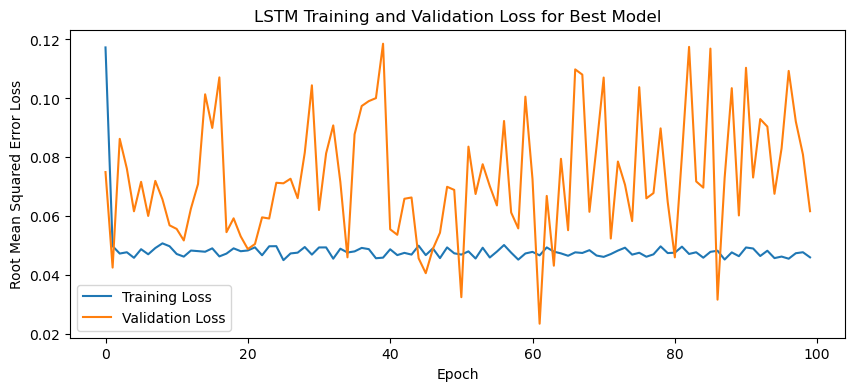

1/1 - 2s - loss: 0.0505 - 2s/epoch - 2s/step
Test Loss: 0.050510112196207047
1/1 [==============================] - 0s 91ms/step


IndexError: index 10 is out of bounds for axis 0 with size 10

In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)
    
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history=best_model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

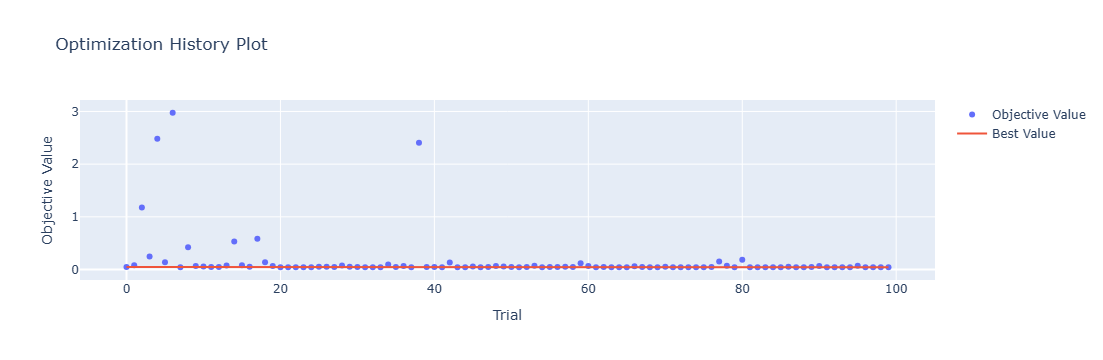

In [4]:
optuna.visualization.plot_optimization_history(study)

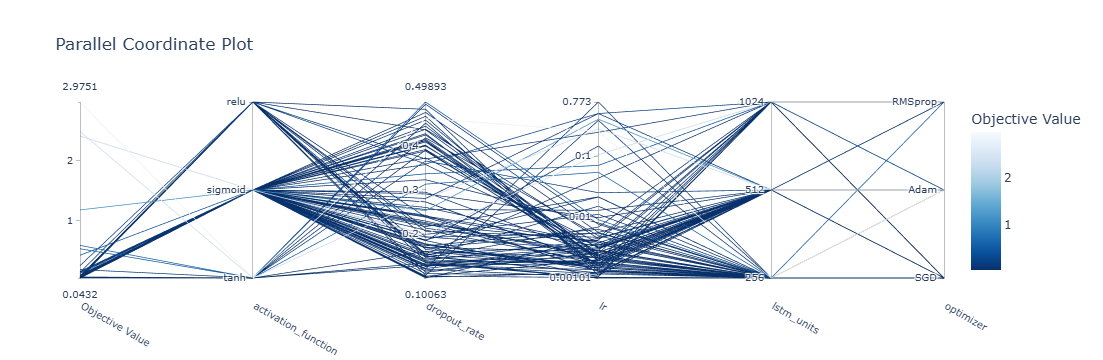

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

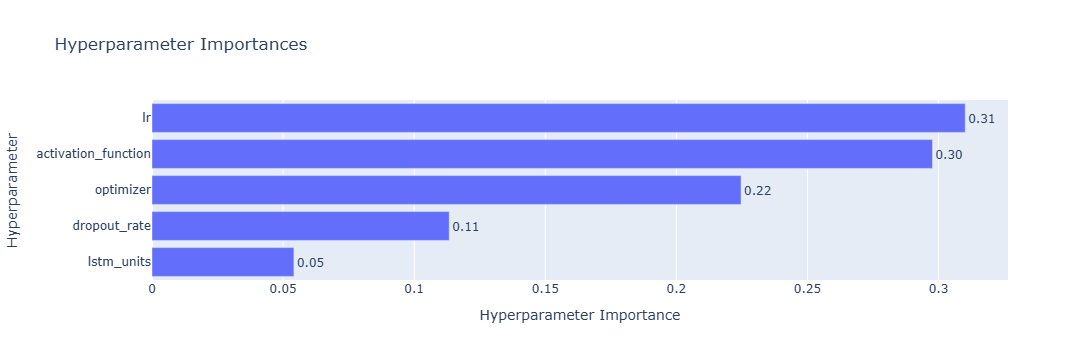

In [6]:
optuna.visualization.plot_param_importances(study)

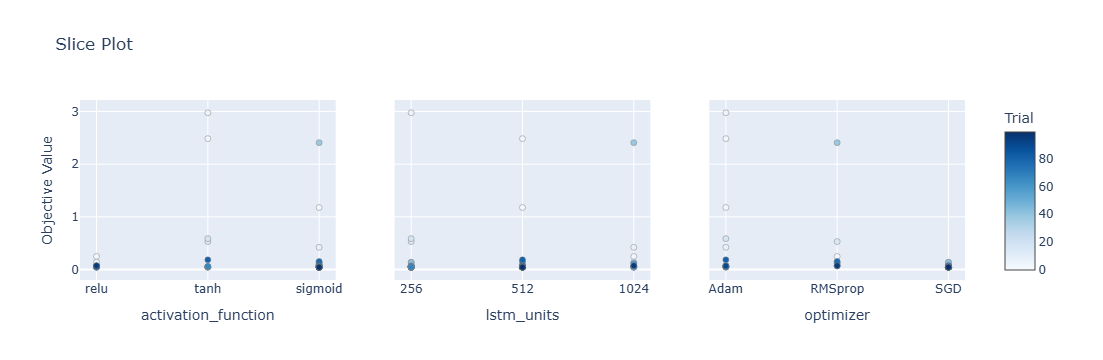

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

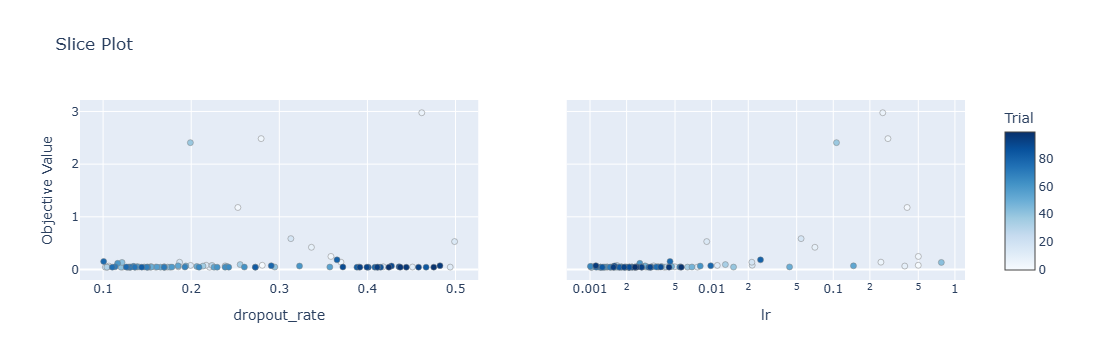

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

Epoch 1/100
84/84 [==============================] - 22s 109ms/step - loss: 0.0866 - accuracy: 0.7143 - mae: 0.0758 - rmse: 0.0866 - mape: 14.2015 - pearson: 0.7271 - val_loss: 0.0319 - val_accuracy: 0.9000 - val_mae: 0.0259 - val_rmse: 0.0319 - val_mape: 5.0520 - val_pearson: 0.7866
Epoch 2/100
84/84 [==============================] - 3s 30ms/step - loss: 0.0489 - accuracy: 0.7976 - mae: 0.0414 - rmse: 0.0489 - mape: 7.7488 - pearson: 0.7069 - val_loss: 0.0339 - val_accuracy: 0.9000 - val_mae: 0.0279 - val_rmse: 0.0339 - val_mape: 5.3599 - val_pearson: 0.8110
Epoch 3/100
84/84 [==============================] - 2s 29ms/step - loss: 0.0500 - accuracy: 0.7976 - mae: 0.0427 - rmse: 0.0500 - mape: 7.9791 - pearson: 0.7162 - val_loss: 0.0426 - val_accuracy: 0.9000 - val_mae: 0.0370 - val_rmse: 0.0426 - val_mape: 7.3426 - val_pearson: 0.6977
Epoch 4/100
84/84 [==============================] - 3s 31ms/step - loss: 0.0480 - accuracy: 0.8095 - mae: 0.0414 - rmse: 0.0480 - mape: 7.7488 - pears

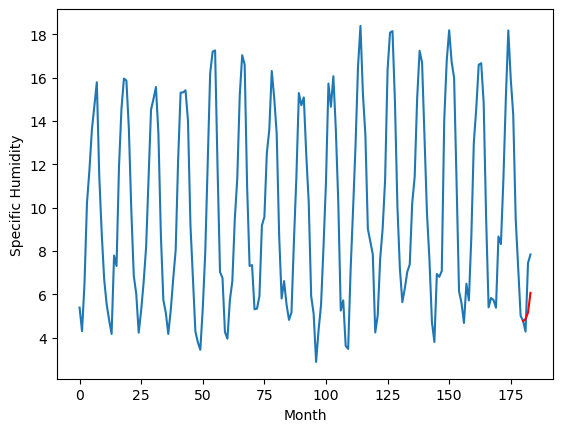

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.90		4.55		-0.35
5.61		4.85		-0.76
7.82		5.76		-2.06
[180, 181, 182, 183]
[7.05, 4.554206869751215, 4.846889547258615, 5.758938721567392]


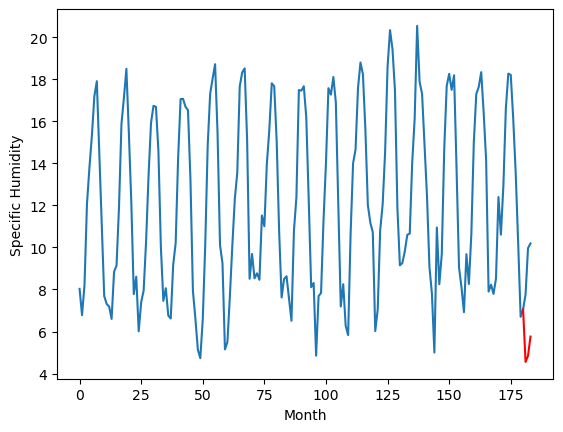

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.82		4.44		-0.38
4.97		4.73		-0.24
6.82		5.64		-1.18
[180, 181, 182, 183]
[5.06, 4.443226547269151, 4.734769405154512, 5.643670738963411]


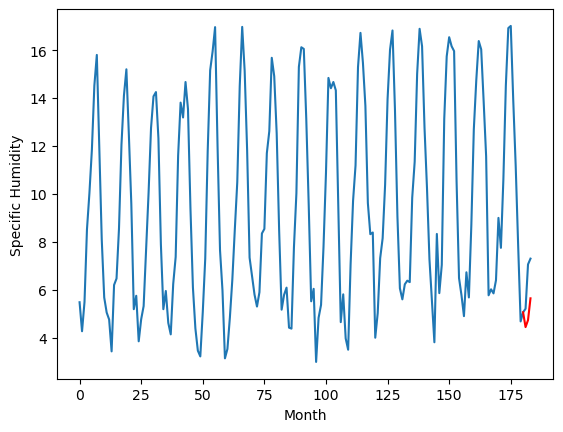

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.21		4.14		-0.07
4.12		4.43		0.31
7.57		5.34		-2.23
[180, 181, 182, 183]
[7.05, 4.143458576276898, 4.432712079361081, 5.340767444446683]


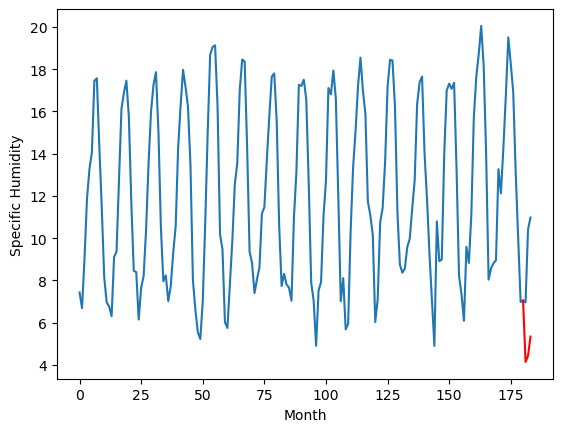

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.32		5.39		0.07
4.92		5.69		0.77
7.76		6.59		-1.17
[180, 181, 182, 183]
[5.2, 5.3937689148448404, 5.686875053551048, 6.593703576233238]


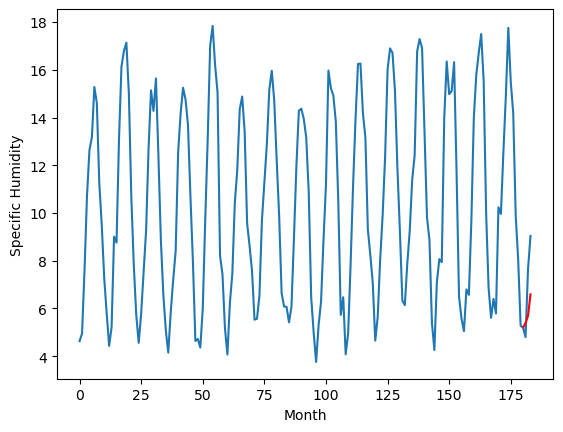

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.42		8.04		0.62
8.01		8.33		0.32
9.58		9.24		-0.34
[180, 181, 182, 183]
[5.16, 8.036259359419345, 8.331558174192905, 9.243157810270786]


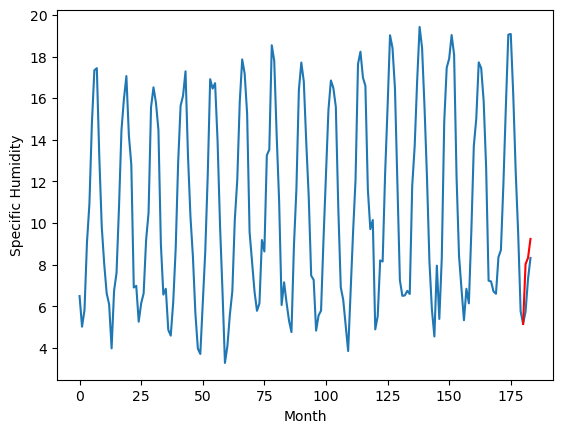

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.33		5.49		0.16
5.38		5.78		0.40
6.97		6.69		-0.28
[180, 181, 182, 183]
[4.05, 5.48619555125013, 5.779105441663415, 6.688915507886559]


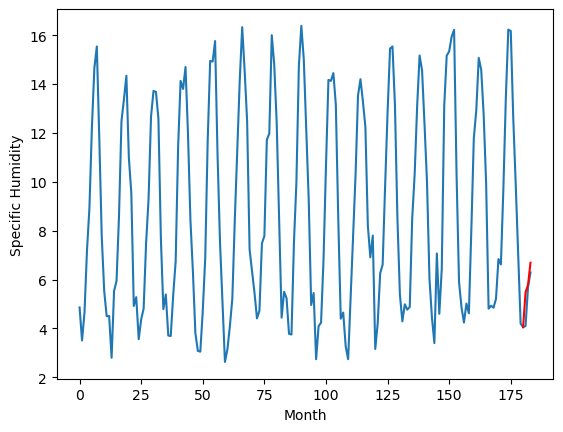

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.12		7.44		0.32
7.15		7.73		0.58
8.77		8.64		-0.13
[180, 181, 182, 183]
[3.64, 7.435574874114245, 7.726436123084277, 8.638120814990252]


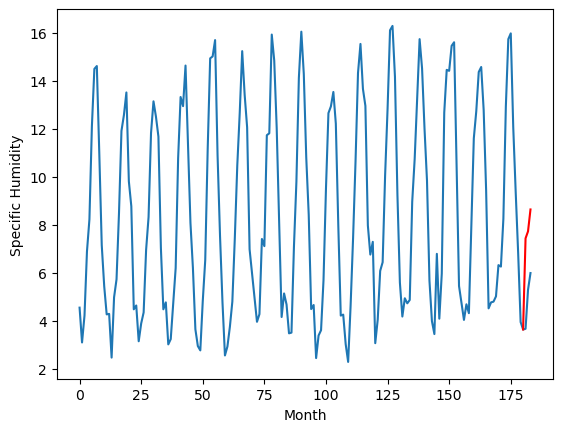

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.40		4.63		0.23
3.72		4.92		1.20
6.78		5.83		-0.95
[180, 181, 182, 183]
[3.46, 4.63482368003577, 4.9212077559158205, 5.834496349208057]


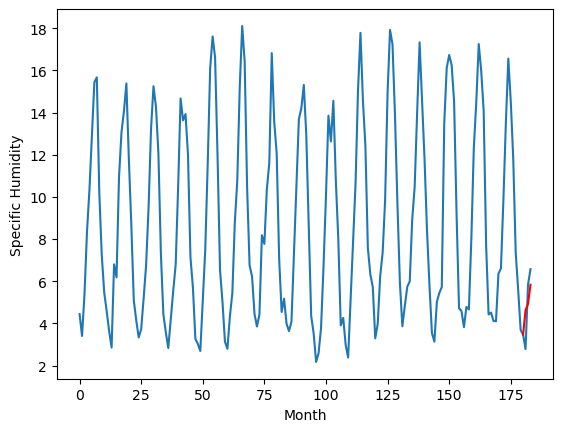

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.17		6.51		0.34
5.72		6.80		1.08
7.52		7.71		0.19
[180, 181, 182, 183]
[2.93, 6.50796767231077, 6.796582124195993, 7.712085626088083]


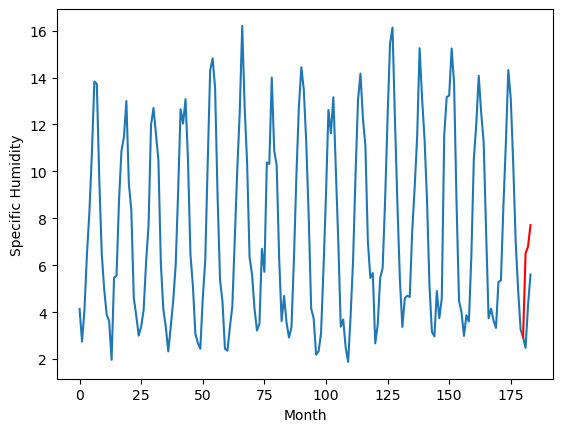

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.48		4.87		0.39
3.74		5.16		1.42
5.36		6.07		0.71
[180, 181, 182, 183]
[2.74, 4.8700143607705835, 5.1584054740518335, 6.074665001258254]


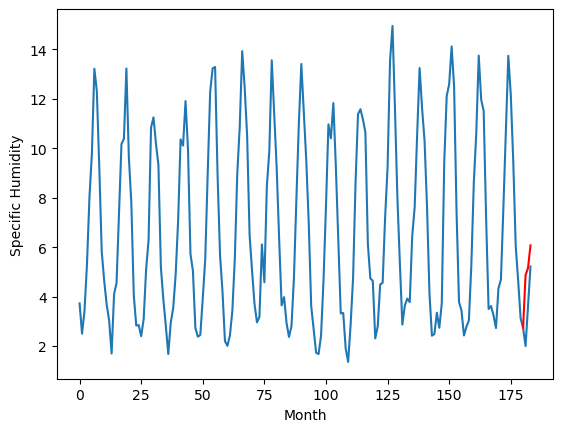

RangeIndex(start=1, stop=12, step=1)
[4.62, 4.899999999999999, 4.820000000000001, 4.209999999999998, 5.32, 7.42, 5.33, 7.119999999999999, 4.4, 6.170000000000001, 4.48]
[4.864316116683185, 4.554206869751215, 4.443226547269151, 4.143458576276898, 5.3937689148448404, 8.036259359419345, 5.48619555125013, 7.435574874114245, 4.63482368003577, 6.50796767231077, 4.8700143607705835]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    4.62   4.864316
1                 1    4.90   4.554207
2                 2    4.82   4.443227
3                 3    4.21   4.143459
4                 4    5.32   5.393769
5                 5    7.42   8.036259
6                 6    5.33   5.486196
7                 7    7.12   7.435575
8                 8    4.40   4.634824
9                 9    6.17   6.507968
10               10    4.48   4.870014


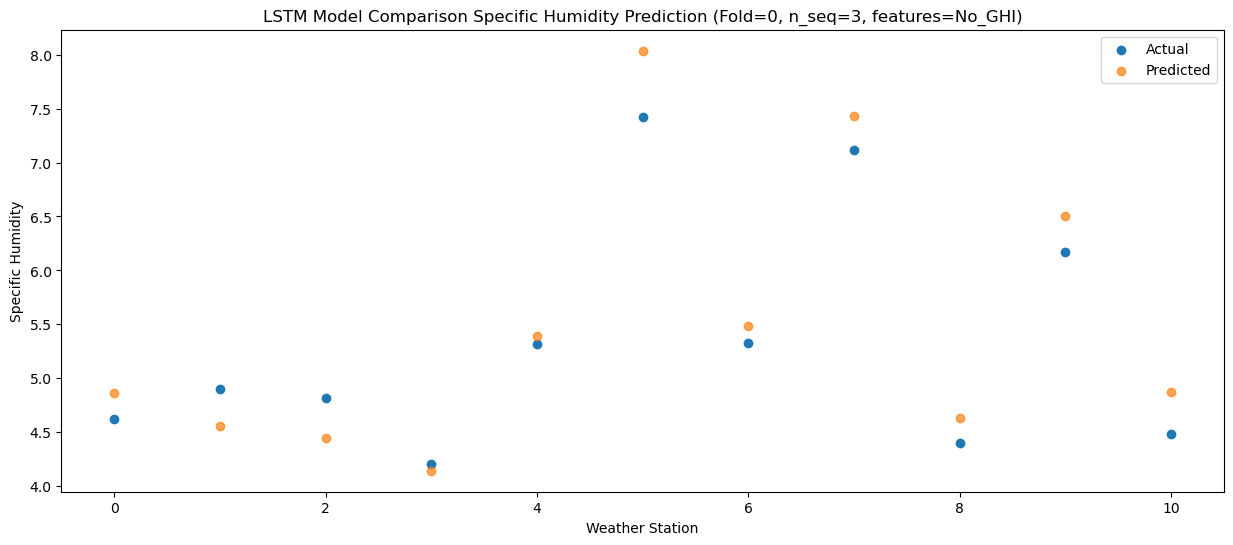

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    4.13   5.157396
1                 1    5.61   4.846890
2                 2    4.97   4.734769
3                 3    4.12   4.432712
4                 4    4.92   5.686875
5                 5    8.01   8.331558
6                 6    5.38   5.779105
7                 7    7.15   7.726436
8                 8    3.72   4.921208
9                 9    5.72   6.796582
10               10    3.74   5.158405


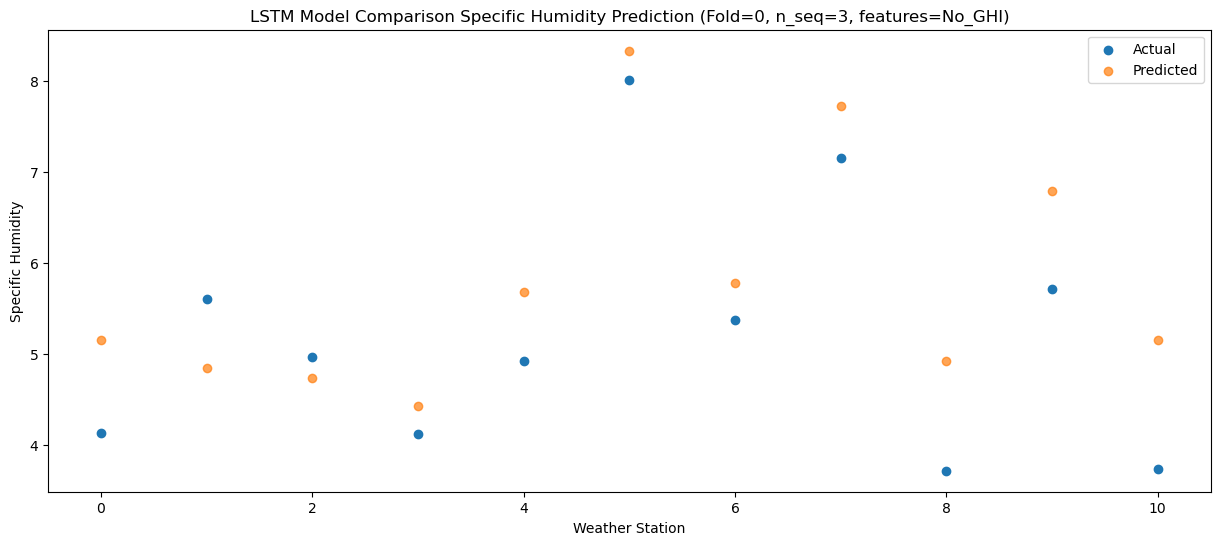

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0    7.30   6.070569
1                 1    7.82   5.758939
2                 2    6.82   5.643671
3                 3    7.57   5.340767
4                 4    7.76   6.593704
5                 5    9.58   9.243158
6                 6    6.97   6.688916
7                 7    8.77   8.638121
8                 8    6.78   5.834496
9                 9    7.52   7.712086
10               10    5.36   6.074665


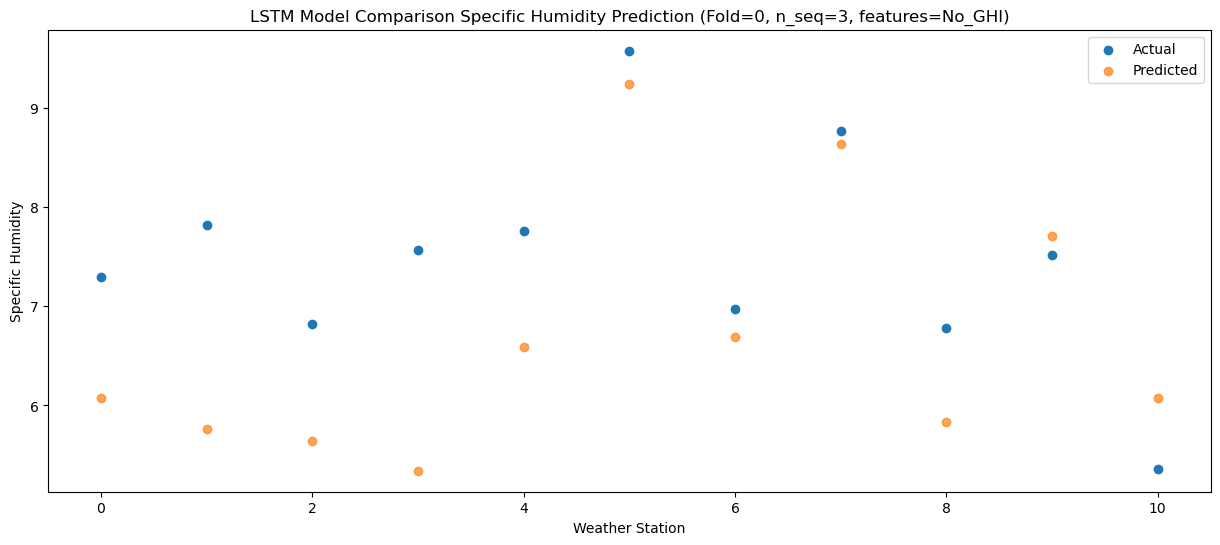

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (1, 1, 512)               5083136   
                                                                 
 dropout_10 (Dropout)        (1, 1, 512)               0         
                                                                 
 lstm_11 (LSTM)              (1, 512)                  2099200   
                                                                 
 dropout_11 (Dropout)        (1, 512)                  0         
                                                                 
 dense_15 (Dense)            (1, 256)                  131328    
                                                                 
 dense_16 (Dense)            (1, 128)                  32896     
                                                                 
 dense_17 (Dense)            (1, 3)                   

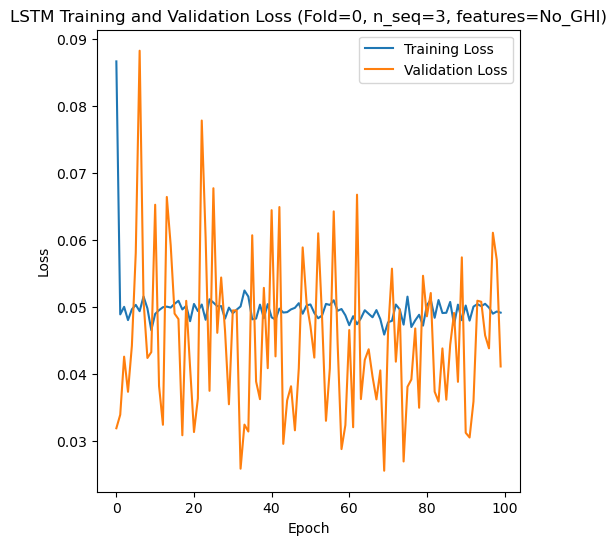

Epoch 1/100
84/84 [==============================] - 22s 82ms/step - loss: 0.0988 - accuracy: 0.8333 - mae: 0.0872 - rmse: 0.0988 - mape: 17.1150 - pearson: 0.7441 - val_loss: 0.0502 - val_accuracy: 0.9000 - val_mae: 0.0402 - val_rmse: 0.0502 - val_mape: 7.3167 - val_pearson: 0.8128
Epoch 2/100
84/84 [==============================] - 2s 27ms/step - loss: 0.0463 - accuracy: 0.8452 - mae: 0.0395 - rmse: 0.0463 - mape: 7.3433 - pearson: 0.7387 - val_loss: 0.0685 - val_accuracy: 0.0000e+00 - val_mae: 0.0537 - val_rmse: 0.0685 - val_mape: 9.5205 - val_pearson: 0.3773
Epoch 3/100
84/84 [==============================] - 2s 29ms/step - loss: 0.0477 - accuracy: 0.8095 - mae: 0.0411 - rmse: 0.0477 - mape: 7.7124 - pearson: 0.7115 - val_loss: 0.0486 - val_accuracy: 0.9000 - val_mae: 0.0415 - val_rmse: 0.0486 - val_mape: 7.8583 - val_pearson: 0.9134
Epoch 4/100
84/84 [==============================] - 2s 28ms/step - loss: 0.0497 - accuracy: 0.8333 - mae: 0.0422 - rmse: 0.0497 - mape: 7.8450 - pe

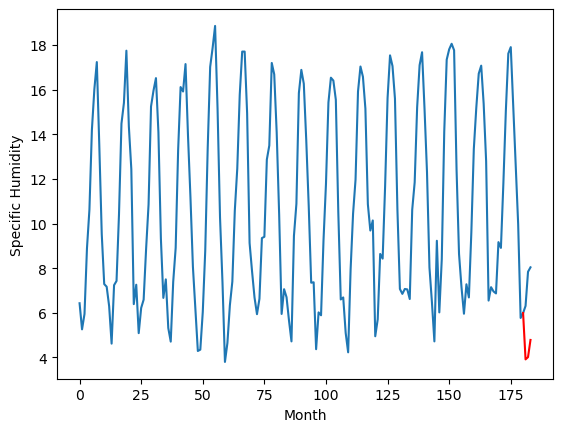

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.34		3.42		-0.92
4.53		3.52		-1.01
6.06		4.29		-1.77
[180, 181, 182, 183]
[4.15, 3.4229261350631717, 3.5203873810172084, 4.290206640660763]


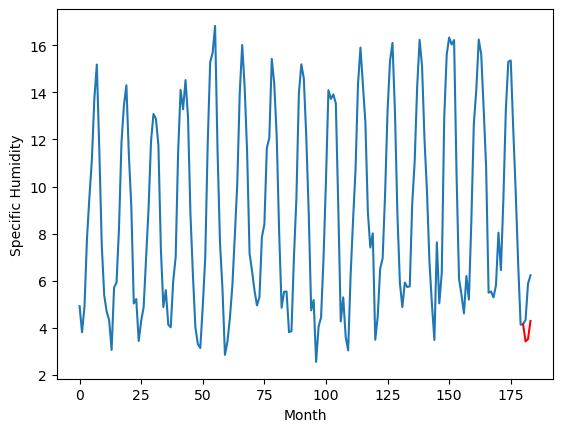

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.22		2.17		-1.05
3.22		2.27		-0.95
5.84		3.04		-2.80
[180, 181, 182, 183]
[5.12, 2.173879392147064, 2.2689197954535483, 3.0393636521697043]


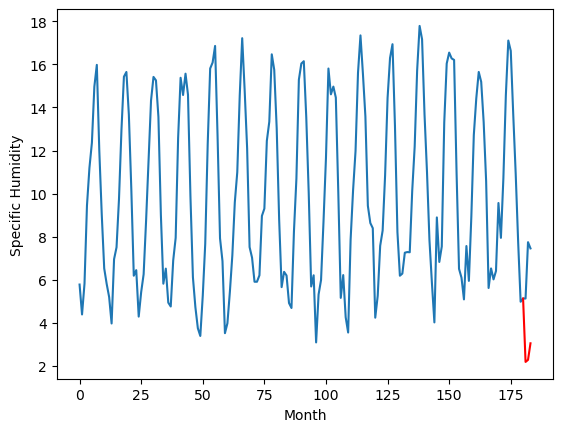

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.03		1.47		-0.56
2.10		1.56		-0.54
4.74		2.33		-2.41
[180, 181, 182, 183]
[6.35, 1.4743347120285035, 1.5647364732623101, 2.334112989604473]


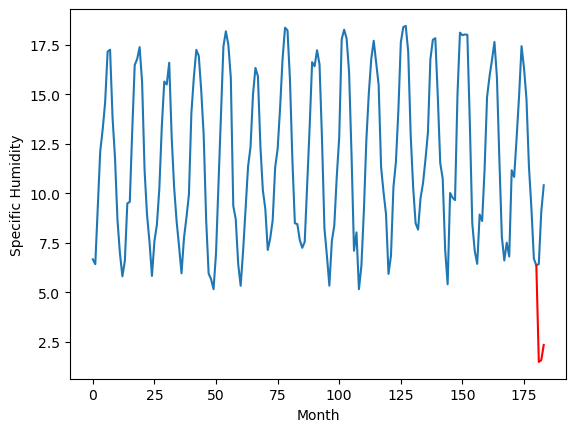

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.18		5.53		-0.65
6.22		5.62		-0.60
8.94		6.39		-2.55
[180, 181, 182, 183]
[6.08, 5.533869199752807, 5.621418938338756, 6.390084848105907]


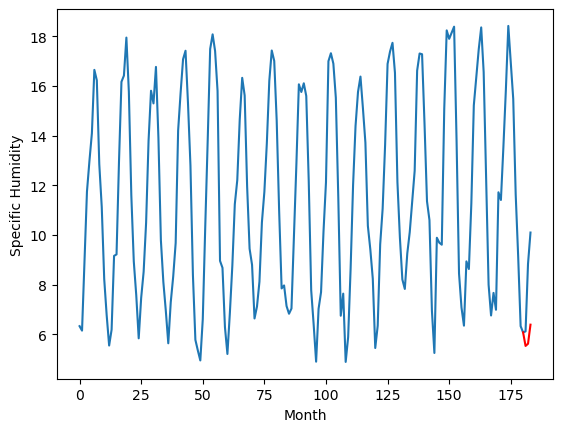

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.75		4.02		-1.73
5.12		4.11		-1.01
5.91		4.88		-1.03
[180, 181, 182, 183]
[3.92, 4.024586601257324, 4.11024820625782, 4.877055941224098]


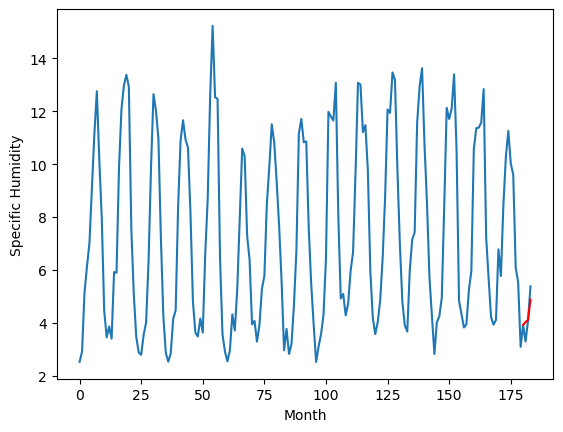

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.66		4.87		-0.79
5.78		4.96		-0.82
7.34		5.73		-1.61
[180, 181, 182, 183]
[4.16, 4.869654972553253, 4.956705850064754, 5.728536051213741]


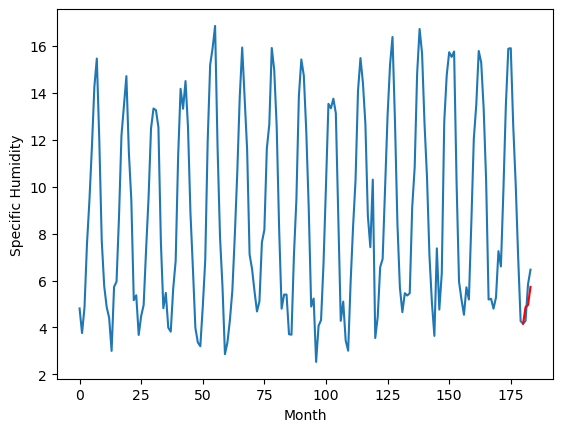

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.53		5.76		-0.77
6.01		5.85		-0.16
8.74		6.62		-2.12
[180, 181, 182, 183]
[3.84, 5.759519193172455, 5.845681588947773, 6.620721500217915]


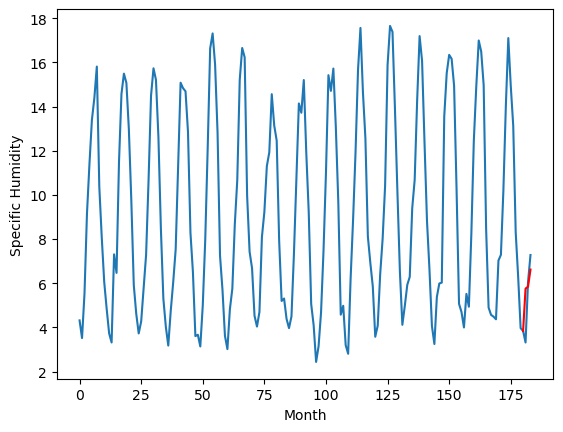

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.49		5.43		-1.06
5.68		5.52		-0.16
8.29		6.29		-2.00
[180, 181, 182, 183]
[3.73, 5.431087272167206, 5.516036355793476, 6.287167573273182]


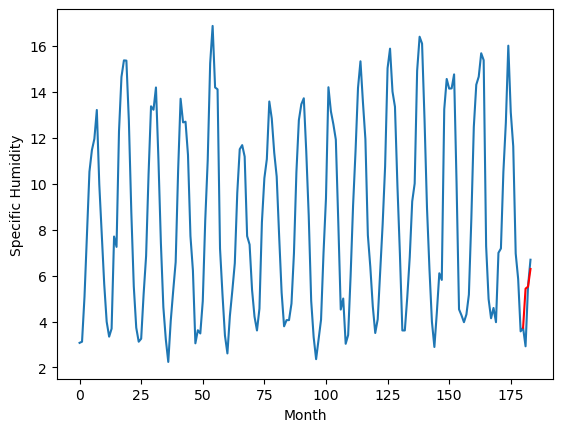

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.71		1.62		-1.09
1.97		1.71		-0.26
3.79		2.48		-1.31
[180, 181, 182, 183]
[2.83, 1.621507842540741, 1.7064404901862145, 2.478161436021328]


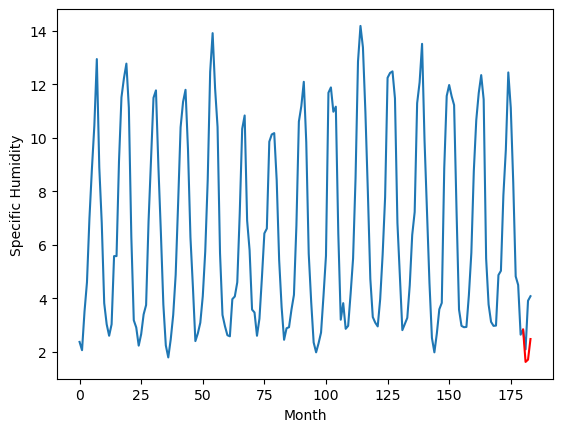

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.08		3.91		-0.17
4.12		3.99		-0.13
5.36		4.77		-0.59
[180, 181, 182, 183]
[2.69, 3.9080269312858578, 3.9947423315048214, 4.76681232213974]
84/84 [==============================] - 2s 23ms/step - loss: 0.0477 - accuracy: 0.8452 - mae: 0.0404 - rmse: 0.0477 - mape: 7.4826 - pearson: 0.7602 - val_loss: 0.0415 - val_accuracy: 1.0000 - val_mae: 0.0326 - val_rmse: 0.0415 - val_mape: 5.9661 - val_pearson: 0.9168
Epoch 88/100
84/84 [==============================] - 2s 23ms/step - loss: 0.0469 - accuracy: 0.8214 - mae: 0.0392 - rmse: 0.0469 - mape: 7.2349 - pearson: 0.7633 - val_loss: 0.0282 - val_accuracy: 1.0000 - val_mae: 0.0230 - val_rmse: 0.0282 - val_mape: 4.2070 - val_pearson: 0.9310
Epoch 89/100
84/84 [==============================] - 2s 23ms/step - loss: 0.0480 - accuracy: 0.8690 - mae: 0.0403 - rmse: 0.0480 - mape: 7.4738 - pearson: 0.7637 - val_loss: 0.0433 - val_accuracy: 1.0000 - val_

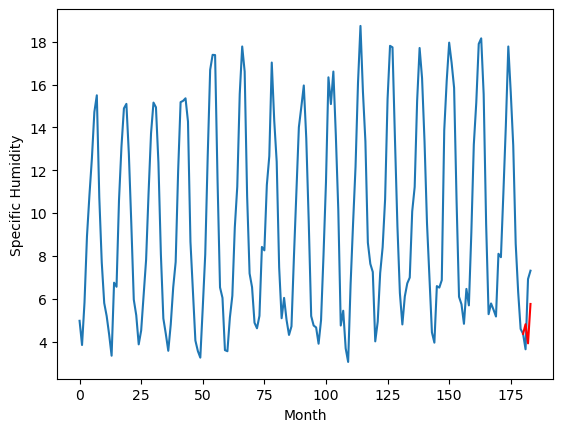

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
1.84		2.09		0.25
1.16		1.20		0.04
3.01		3.03		0.02
[180, 181, 182, 183]
[2.82, 2.0888177895545956, 1.1962674999237057, 3.0294791603088376]


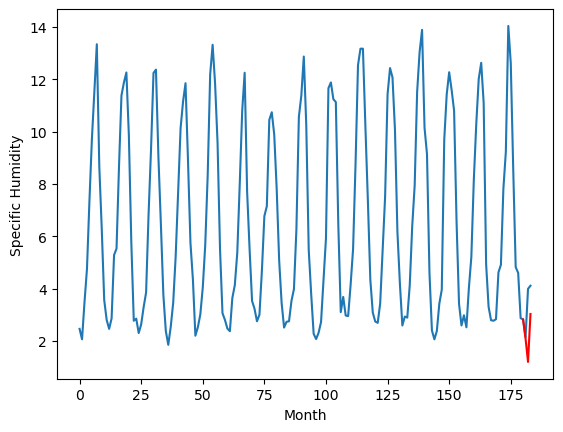

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.53		5.23		-0.30
7.66		4.34		-3.32
7.88		6.18		-1.70
[180, 181, 182, 183]
[9.16, 5.232517071962357, 4.343653985261917, 6.177811094522476]


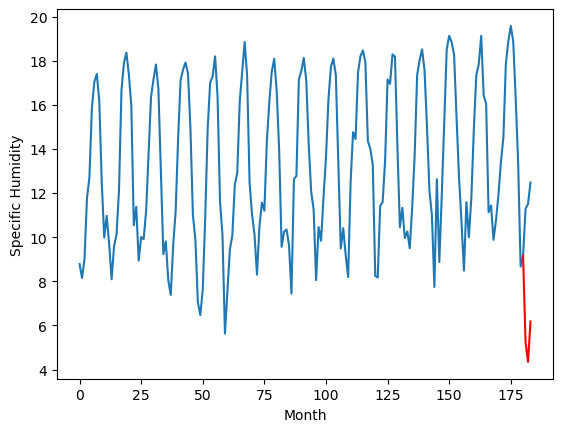

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.98		5.25		1.27
4.15		4.37		0.22
4.79		6.20		1.41
[180, 181, 182, 183]
[2.44, 5.253837940692901, 4.368325409889221, 6.201998767852783]


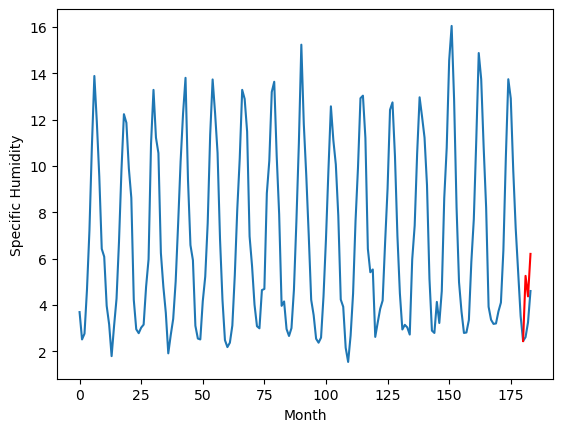

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.10		5.16		0.06
5.08		4.28		-0.80
8.37		6.11		-2.26
[180, 181, 182, 183]
[6.65, 5.161761329770088, 4.27553950369358, 6.109161124825477]


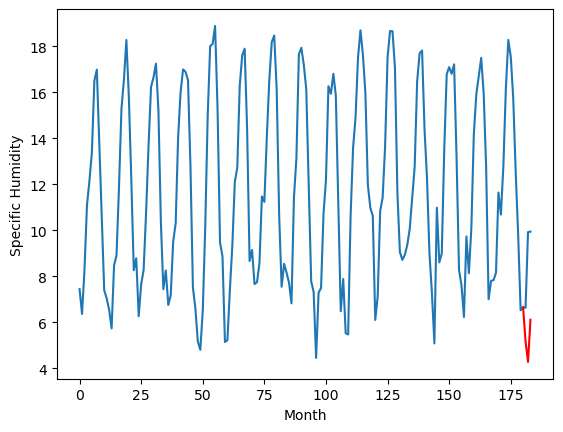

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.33		2.65		0.32
2.28		1.77		-0.51
5.27		3.61		-1.66
[180, 181, 182, 183]
[6.19, 2.654487363100052, 1.7684643185138702, 3.6078703320026397]


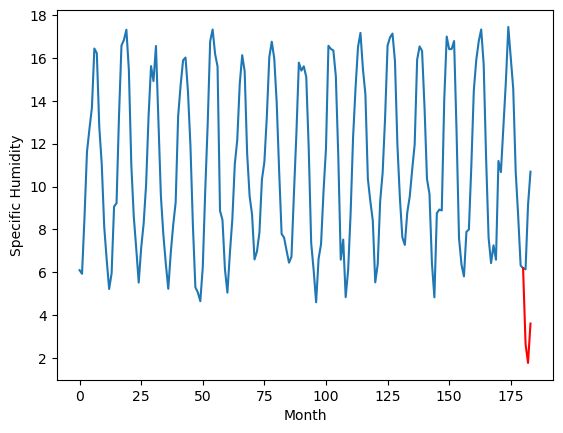

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.68		8.97		0.29
8.35		8.09		-0.26
11.21		9.92		-1.29
[180, 181, 182, 183]
[4.78, 8.97369426369667, 8.085136293172836, 9.924781798124313]


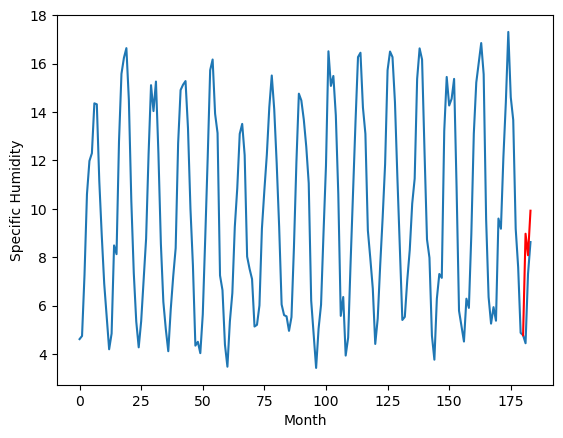

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.97		3.89		-0.08
3.84		3.00		-0.84
3.93		4.83		0.90
[180, 181, 182, 183]
[2.61, 3.8886195147037506, 3.001835914850235, 4.83218845963478]


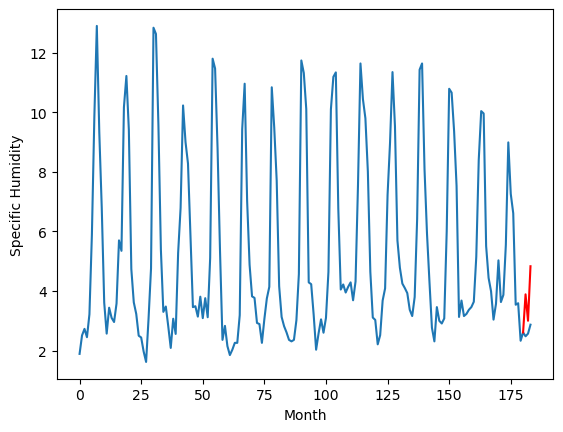

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.29		7.64		-0.65
8.82		6.75		-2.07
8.93		8.58		-0.35
[180, 181, 182, 183]
[4.6, 7.639461460113526, 6.752471926212311, 8.583337786197664]


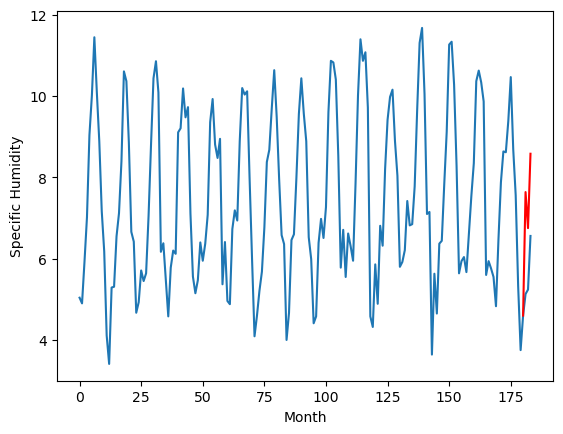

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.98		6.30		0.32
6.05		5.41		-0.64
7.78		7.25		-0.53
[180, 181, 182, 183]
[4.27, 6.296705728769302, 5.409398204088211, 7.246206647157669]


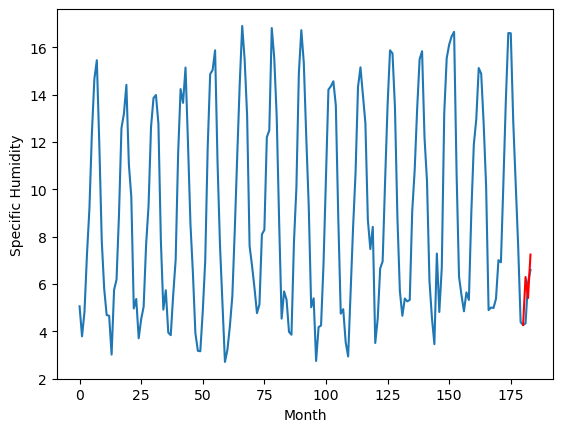

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.63		4.81		0.18
4.87		3.93		-0.94
5.90		5.76		-0.14
[180, 181, 182, 183]
[3.91, 4.813598479032517, 3.9265591752529145, 5.7636117589473725]


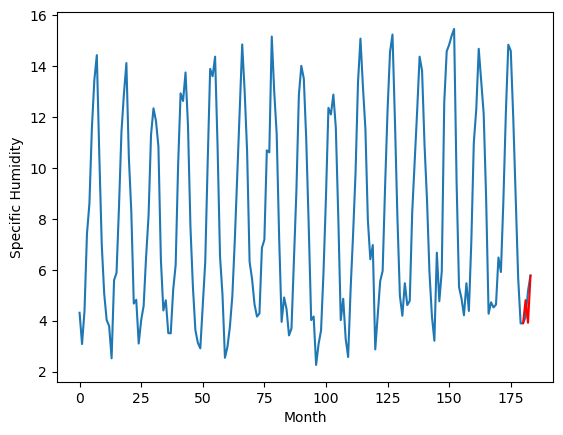

RangeIndex(start=1, stop=12, step=1)
[4.390000000000001, 1.8399999999999992, 5.529999999999999, 3.9799999999999995, 5.1, 2.33, 8.68, 3.9700000000000006, 8.29, 5.9799999999999995, 4.63]
[4.81230155646801, 2.0888177895545956, 5.232517071962357, 5.253837940692901, 5.161761329770088, 2.654487363100052, 8.97369426369667, 3.8886195147037506, 7.639461460113526, 6.296705728769302, 4.813598479032517]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    4.39   4.812302
1                 1    1.84   2.088818
2                 2    5.53   5.232517
3                 3    3.98   5.253838
4                 4    5.10   5.161761
5                 5    2.33   2.654487
6                 6    8.68   8.973694
7                 7    3.97   3.888620
8                 8    8.29   7.639461
9                 9    5.98   6.296706
10               10    4.63   4.813598


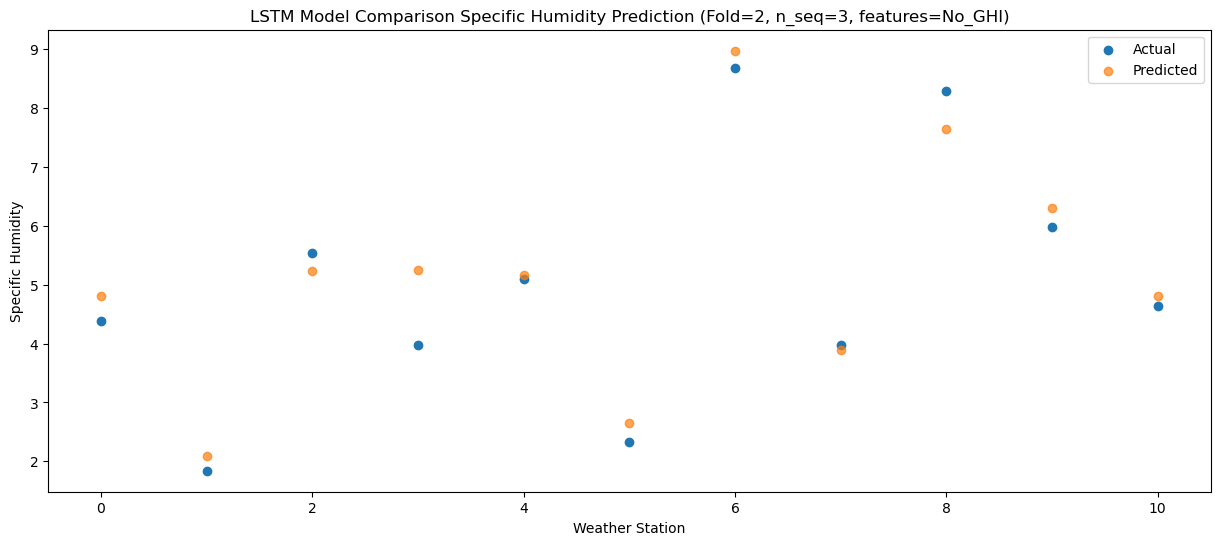

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    3.67   3.917270
1                 1    1.16   1.196267
2                 2    7.66   4.343654
3                 3    4.15   4.368325
4                 4    5.08   4.275540
5                 5    2.28   1.768464
6                 6    8.35   8.085136
7                 7    3.84   3.001836
8                 8    8.82   6.752472
9                 9    6.05   5.409398
10               10    4.87   3.926559


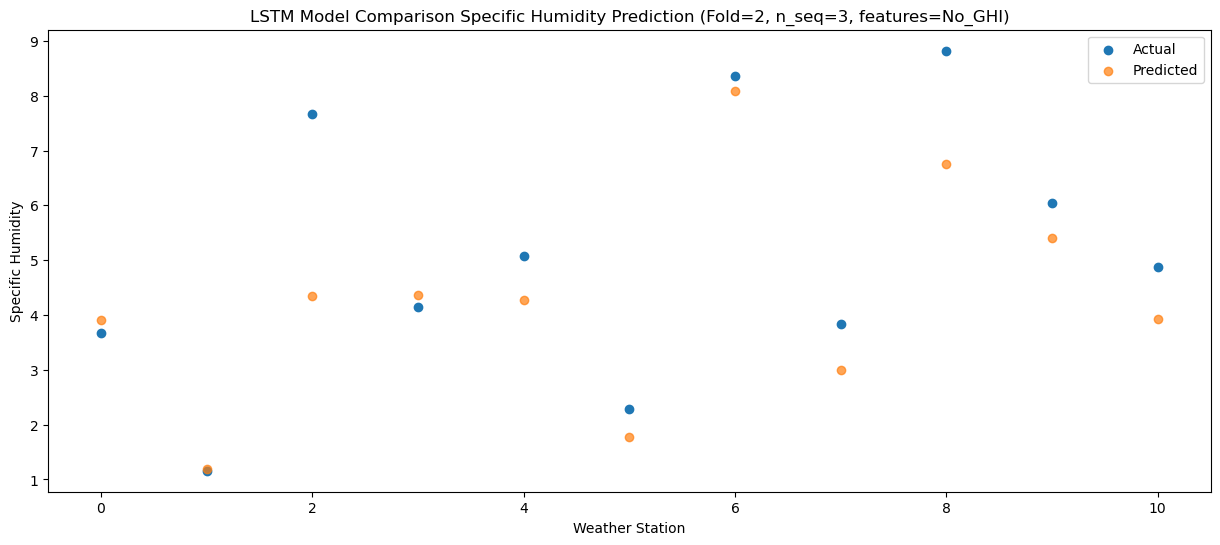

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0    6.95   5.756936
1                 1    3.01   3.029479
2                 2    7.88   6.177811
3                 3    4.79   6.201999
4                 4    8.37   6.109161
5                 5    5.27   3.607870
6                 6   11.21   9.924782
7                 7    3.93   4.832188
8                 8    8.93   8.583338
9                 9    7.78   7.246207
10               10    5.90   5.763612


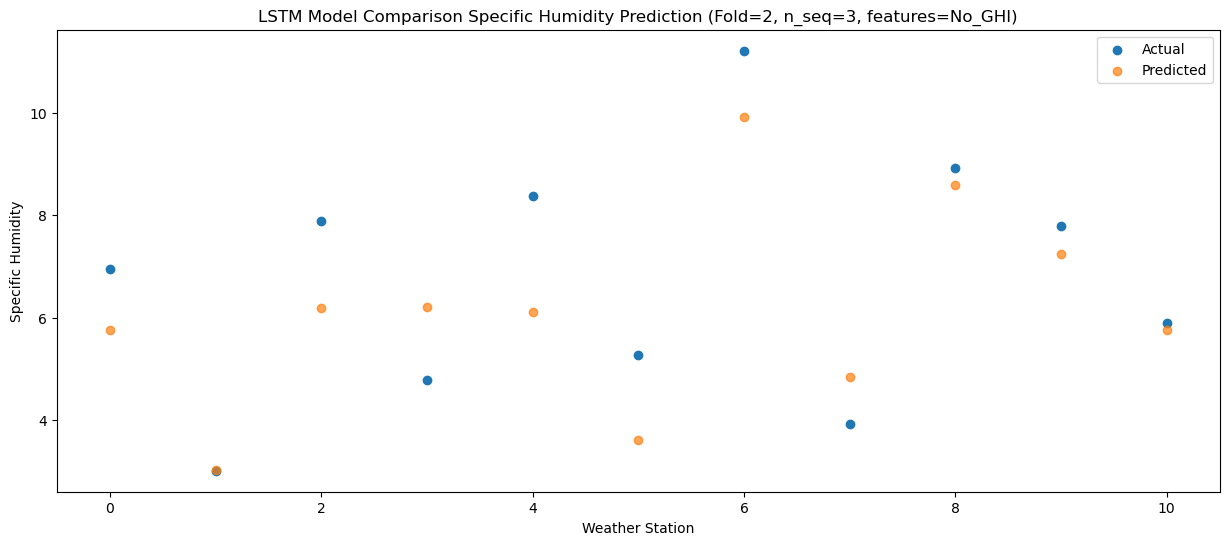

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (1, 1, 512)               5083136   
                                                                 
 dropout_14 (Dropout)        (1, 1, 512)               0         
                                                                 
 lstm_15 (LSTM)              (1, 512)                  2099200   
                                                                 
 dropout_15 (Dropout)        (1, 512)                  0         
                                                                 
 dense_21 (Dense)            (1, 256)                  131328    
                                                                 
 dense_22 (Dense)            (1, 128)                  32896     
                                                                 
 dense_23 (Dense)            (1, 3)                   

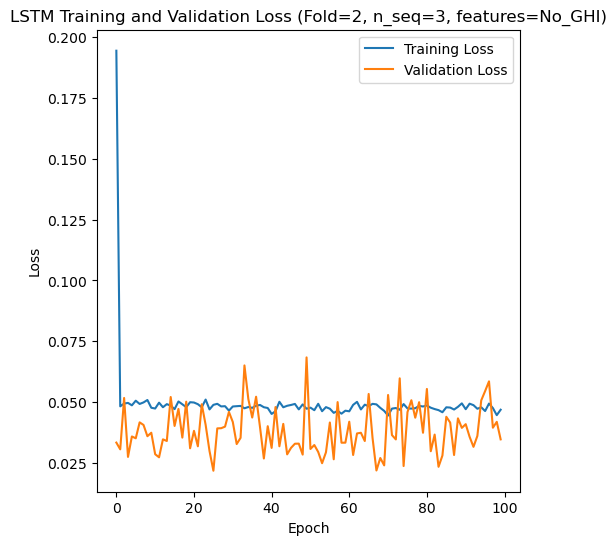

Epoch 1/100
84/84 [==============================] - 12s 39ms/step - loss: 0.1775 - accuracy: 0.6786 - mae: 0.1612 - rmse: 0.1775 - mape: 30.0100 - pearson: 0.7553 - val_loss: 0.0760 - val_accuracy: 0.0000e+00 - val_mae: 0.0650 - val_rmse: 0.0760 - val_mape: 12.5223 - val_pearson: 0.5533
Epoch 2/100
84/84 [==============================] - 1s 16ms/step - loss: 0.0474 - accuracy: 0.8571 - mae: 0.0400 - rmse: 0.0474 - mape: 7.3838 - pearson: 0.7689 - val_loss: 0.0307 - val_accuracy: 0.8000 - val_mae: 0.0279 - val_rmse: 0.0307 - val_mape: 5.3291 - val_pearson: 0.8379
Epoch 3/100
84/84 [==============================] - 1s 16ms/step - loss: 0.0490 - accuracy: 0.8929 - mae: 0.0410 - rmse: 0.0490 - mape: 7.5562 - pearson: 0.7985 - val_loss: 0.0469 - val_accuracy: 0.8000 - val_mae: 0.0429 - val_rmse: 0.0469 - val_mape: 8.4746 - val_pearson: 0.6332
Epoch 4/100
84/84 [==============================] - 1s 16ms/step - loss: 0.0480 - accuracy: 0.8929 - mae: 0.0405 - rmse: 0.0480 - mape: 7.5376 - p

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



84/84 [==============================] - 8s 32ms/step - loss: 0.1880 - accuracy: 0.8214 - mae: 0.1574 - rmse: 0.1880 - mape: 31.5699 - pearson: 0.7450 - val_loss: 0.0477 - val_accuracy: 0.9000 - val_mae: 0.0387 - val_rmse: 0.0477 - val_mape: 6.9897 - val_pearson: 0.5821
Epoch 2/100
84/84 [==============================] - 1s 15ms/step - loss: 0.0500 - accuracy: 0.8690 - mae: 0.0416 - rmse: 0.0500 - mape: 7.7526 - pearson: 0.7830 - val_loss: 0.0370 - val_accuracy: 0.9000 - val_mae: 0.0318 - val_rmse: 0.0370 - val_mape: 5.9045 - val_pearson: 0.7499
Epoch 3/100
84/84 [==============================] - 1s 15ms/step - loss: 0.0490 - accuracy: 0.8571 - mae: 0.0410 - rmse: 0.0490 - mape: 7.6774 - pearson: 0.7379 - val_loss: 0.0398 - val_accuracy: 0.9000 - val_mae: 0.0310 - val_rmse: 0.0398 - val_mape: 5.5427 - val_pearson: 0.7250
Epoch 4/100
84/84 [==============================] - 1s 15ms/step - loss: 0.0476 - accuracy: 0.8333 - mae: 0.0402 - rmse: 0.0476 - mape: 7.6079 - pearson: 0.7308 - v

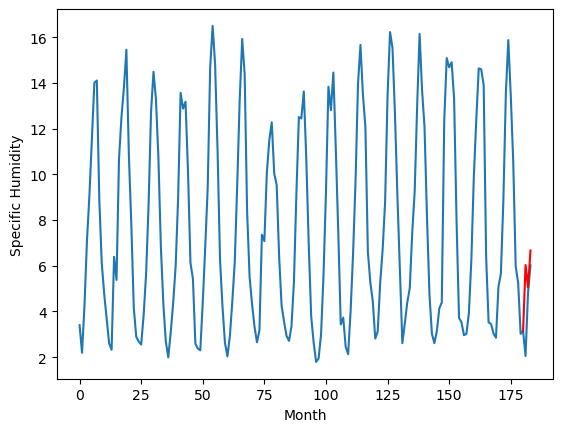

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.27		4.72		0.45
6.26		3.75		-2.51
6.23		5.36		-0.87
[180, 181, 182, 183]
[7.79, 4.723977787494659, 3.7511126232147216, 5.360992712974548]


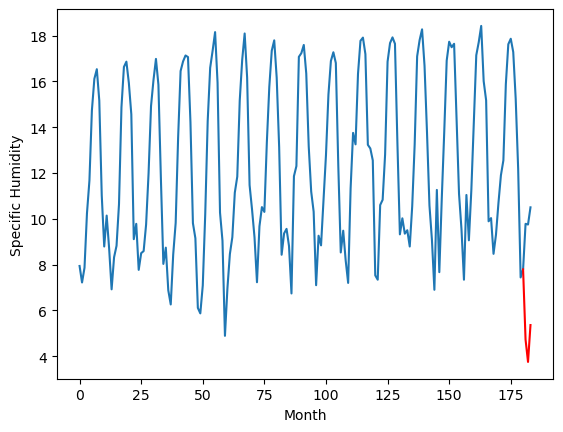

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.87		4.79		0.92
3.75		3.82		0.07
6.81		5.43		-1.38
[180, 181, 182, 183]
[5.03, 4.789110462665558, 3.8192224907875065, 5.430181543827057]


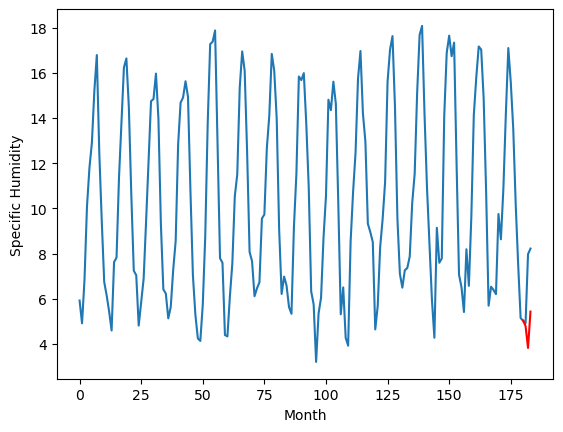

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.73		4.65		0.92
3.41		3.68		0.27
6.07		5.29		-0.78
[180, 181, 182, 183]
[4.41, 4.653170969486236, 3.6814210081100462, 5.294374551773071]


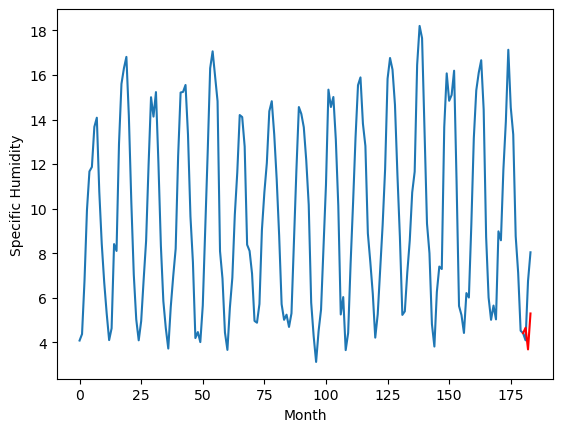

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.36		4.21		0.85
2.91		3.24		0.33
5.49		4.85		-0.64
[180, 181, 182, 183]
[4.29, 4.211050832271576, 3.2379575014114383, 4.8484409093856815]


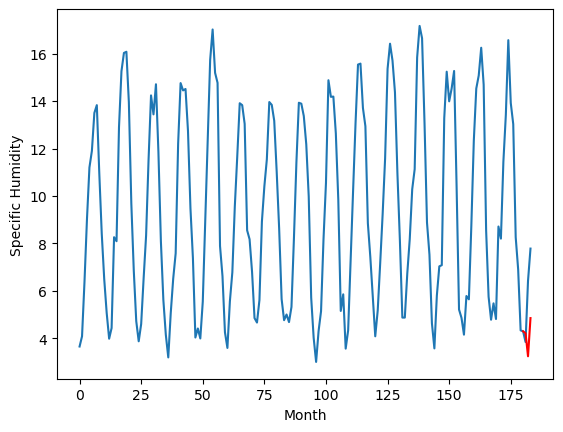

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.64		8.74		0.10
8.00		7.77		-0.23
9.49		9.37		-0.12
[180, 181, 182, 183]
[3.47, 8.743854048252107, 7.765690388679506, 9.373610796928407]


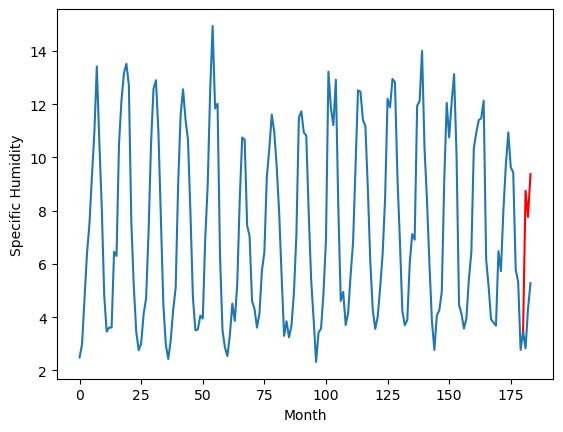

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.80		6.72		0.92
6.05		5.75		-0.30
7.76		7.36		-0.40
[180, 181, 182, 183]
[4.52, 6.720381362438202, 5.7509985399246215, 7.3613301944732665]


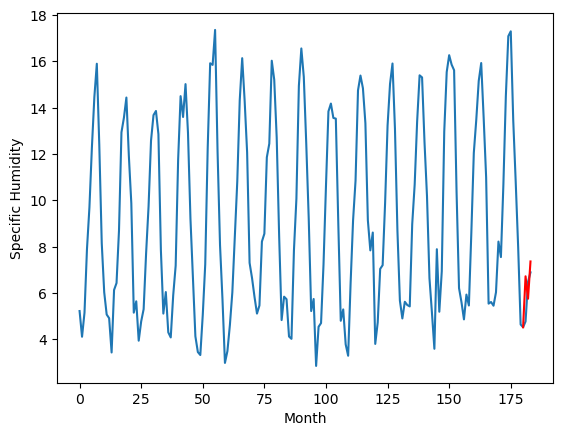

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.93		4.88		0.95
3.30		3.91		0.61
5.67		5.52		-0.15
[180, 181, 182, 183]
[3.4, 4.881882803440094, 3.9123771953582764, 5.524899559020996]


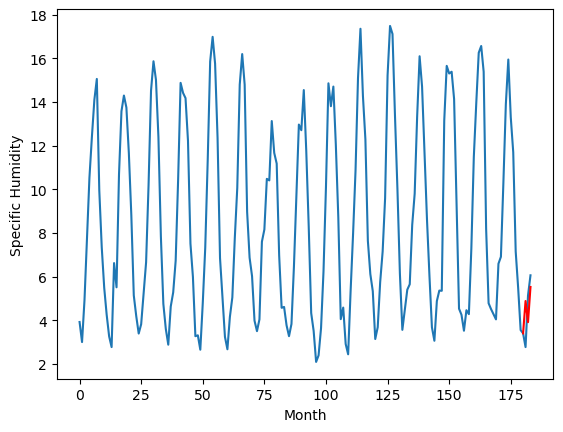

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.30		4.45		1.15
2.73		3.48		0.75
4.67		5.09		0.42
[180, 181, 182, 183]
[2.82, 4.450081670284272, 3.4842053890228275, 5.093705558776856]


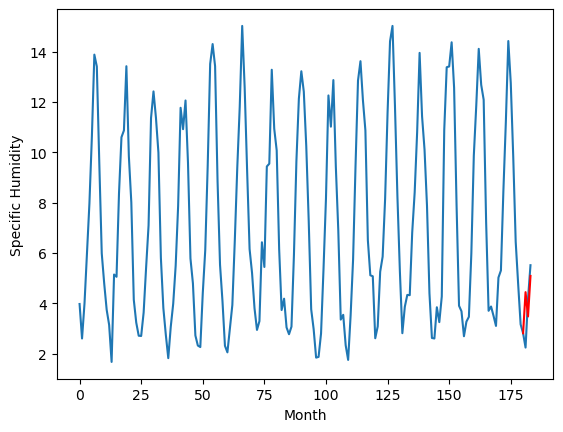

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.17		3.29		1.12
1.53		2.33		0.80
3.90		3.94		0.04
[180, 181, 182, 183]
[2.86, 3.2924957180023195, 2.3291287326812746, 3.942375173568726]


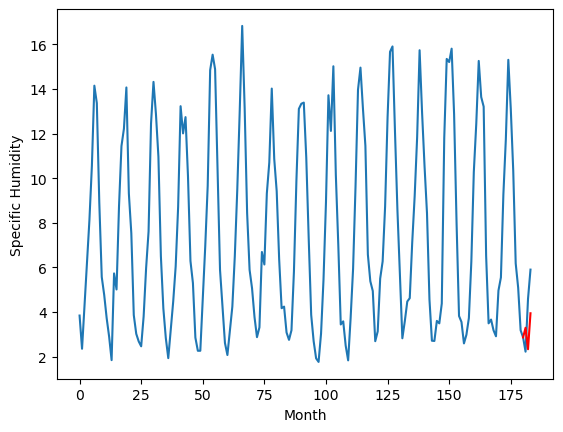

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.84		6.02		1.18
4.27		5.06		0.79
5.56		6.67		1.11
[180, 181, 182, 183]
[2.61, 6.019094557762146, 5.058444769382477, 6.671062858104706]


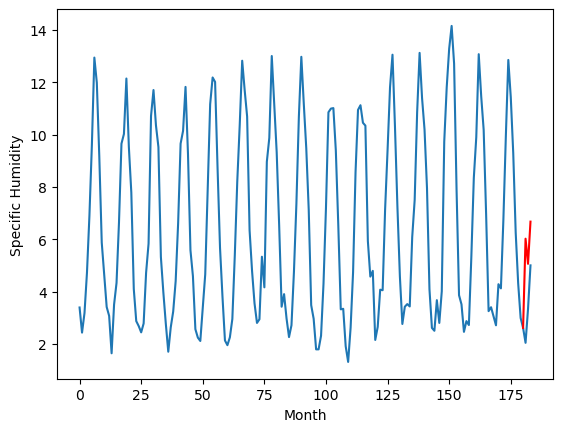

RangeIndex(start=1, stop=12, step=1)
[5.34, 4.269999999999999, 3.870000000000001, 3.7300000000000004, 3.3600000000000003, 8.64, 5.8, 3.93, 3.3000000000000003, 2.1699999999999995, 4.839999999999999]
[6.031496496200561, 4.723977787494659, 4.789110462665558, 4.653170969486236, 4.211050832271576, 8.743854048252107, 6.720381362438202, 4.881882803440094, 4.450081670284272, 3.2924957180023195, 6.019094557762146]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    5.34   6.031496
1                 1    4.27   4.723978
2                 2    3.87   4.789110
3                 3    3.73   4.653171
4                 4    3.36   4.211051
5                 5    8.64   8.743854
6                 6    5.80   6.720381
7                 7    3.93   4.881883
8                 8    3.30   4.450082
9                 9    2.17   3.292496
10               10    4.84   6.019095


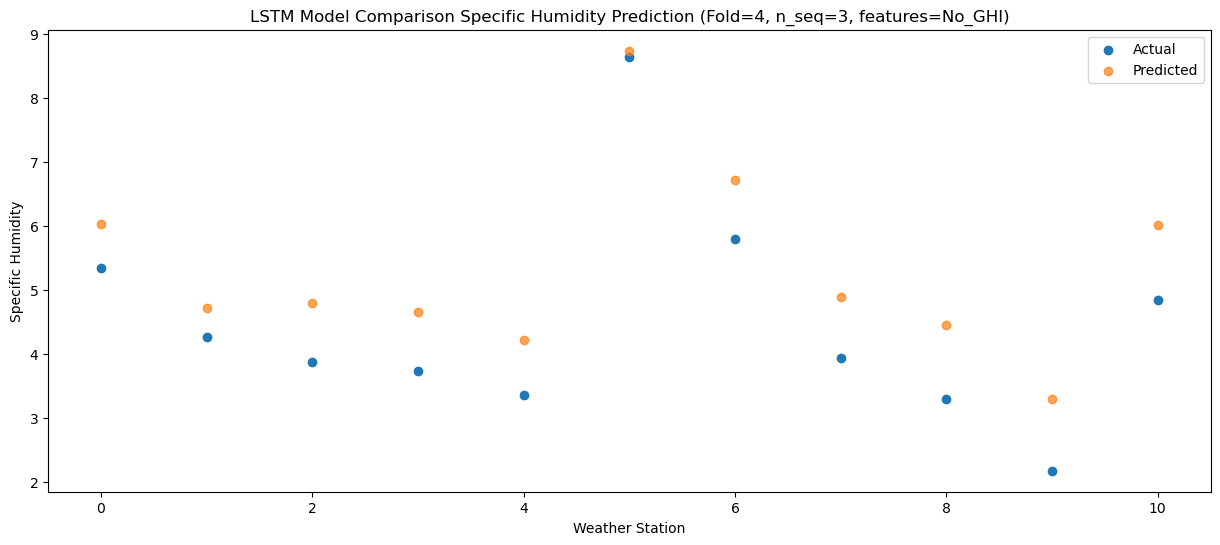

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    4.25   5.053641
1                 1    6.26   3.751113
2                 2    3.75   3.819222
3                 3    3.41   3.681421
4                 4    2.91   3.237958
5                 5    8.00   7.765690
6                 6    6.05   5.750999
7                 7    3.30   3.912377
8                 8    2.73   3.484205
9                 9    1.53   2.329129
10               10    4.27   5.058445


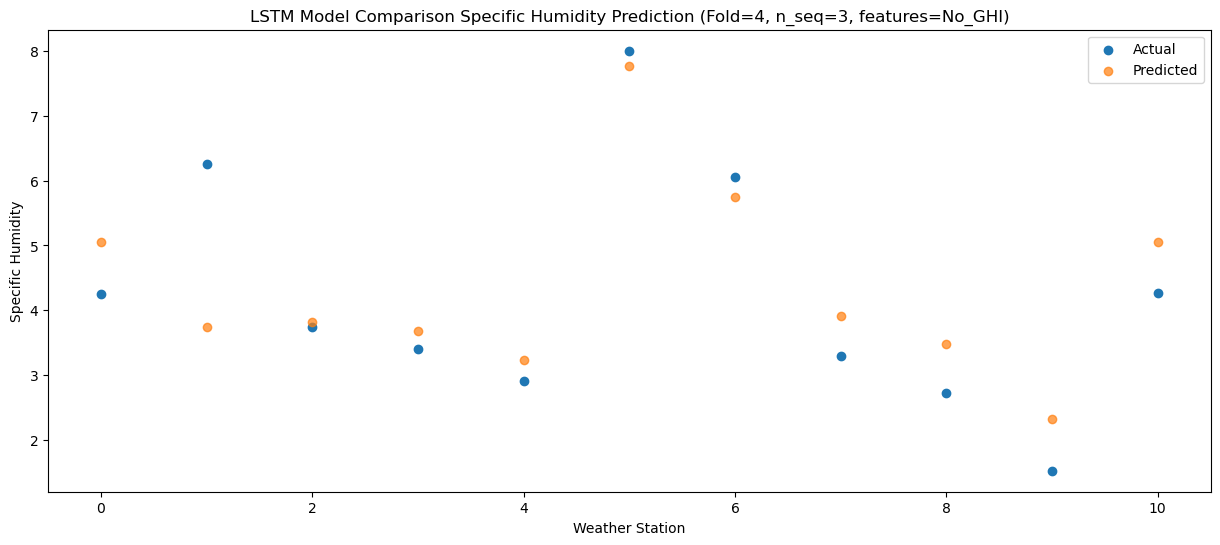

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0    7.01   6.670131
1                 1    6.23   5.360993
2                 2    6.81   5.430182
3                 3    6.07   5.294375
4                 4    5.49   4.848441
5                 5    9.49   9.373611
6                 6    7.76   7.361330
7                 7    5.67   5.524900
8                 8    4.67   5.093706
9                 9    3.90   3.942375
10               10    5.56   6.671063


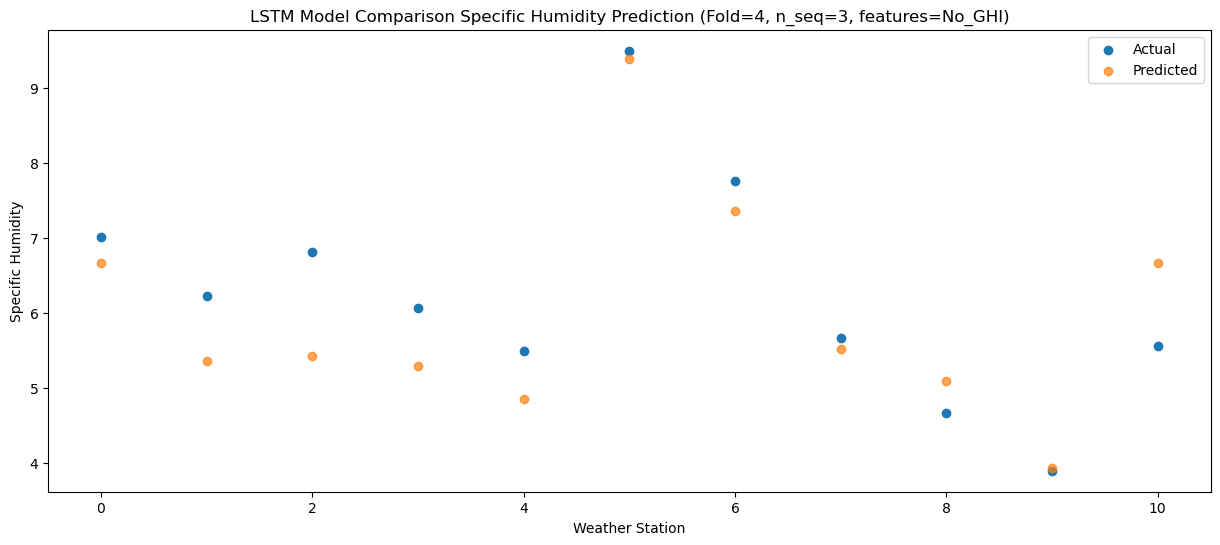

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (1, 1, 512)               5083136   
                                                                 
 dropout_18 (Dropout)        (1, 1, 512)               0         
                                                                 
 lstm_19 (LSTM)              (1, 512)                  2099200   
                                                                 
 dropout_19 (Dropout)        (1, 512)                  0         
                                                                 
 dense_27 (Dense)            (1, 256)                  131328    
                                                                 
 dense_28 (Dense)            (1, 128)                  32896     
                                                                 
 dense_29 (Dense)            (1, 3)                   

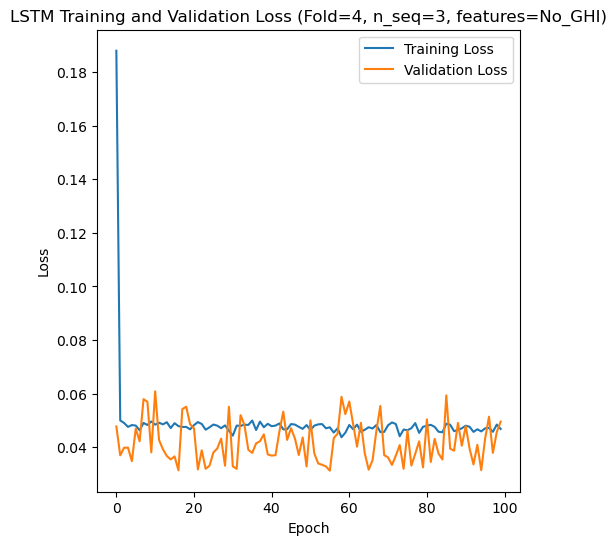

[[0.32422309402128646, 0.8305456411858149, 1.1725819929276973], [0.9741563966853807, 0.7499405314225014, 1.9515288669820792], [0.4964057188900911, 1.2921052329201164, 1.2460292404314632], [0.6271073327292415, 0.8736317977437825, 0.6343340640586603], [0.8965832256120726, 0.9280849256751739, 0.7004607294400607]]
[[0.2870935032846911, 0.7362381292871114, 0.9513100829610427], [0.8988096614317462, 0.6344882205941463, 1.8447704956206414], [0.37769149130040947, 0.8989820997281506, 1.0412681575254956], [0.5295479188182136, 0.6942335153709758, 0.5551977782899681], [0.842417882572521, 0.6789632990143514, 0.5675620510361413]]
[[0.053015985684878156, 0.15901918064507603, 0.13073601909735727], [0.20918769274843757, 0.1526261702814709, 0.2912787815823084], [0.0892795200062821, 0.15917493599719423, 0.15901798493326005], [0.22134219334976918, 0.2069113169269227, 0.13470451578346992], [0.22694682444858713, 0.18619332872007932, 0.0932621501418708]]
[[0.9041702751251774, 0.5991083018660537, -0.2613977162

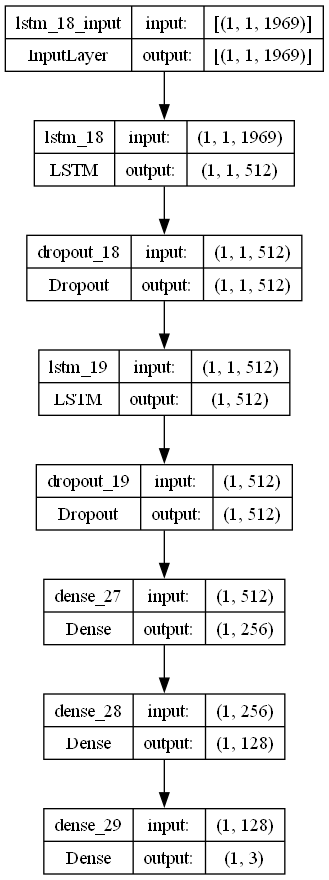

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# fit best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from best model
    lr = 0.0030357832121815937
    optimizer = SGD(learning_rate = lr)
    activation_function = 'sigmoid'
    lstm_units = 512
    dropout_rate = 0.12743527193059515

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with an LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # Create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test, n_seq, n_lag):
    # plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse_avg_list = []
mae_avg_list = []
mape_avg_list = []
r2_score_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (specific humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction

    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse_avg_list.append(rmse_list)
    mae_avg_list.append(mae_list)
    mape_avg_list.append(mape_list)
    r2_score_avg_list.append(r2_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)

    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        
        plot_forecasts(series_ws, forecasts_ws, n_test, n_seq, n_lag)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)
            
        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()

    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse_avg_list)
print(mae_avg_list)
print(mape_avg_list)
print(r2_score_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse_avg_list)
print("Average RMSE:"+str(np.mean(rmse_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S3_No_GHI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)